In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import os
from spot_pattern_generator_functions import SpotGenerator
from skimage.io import imread, imsave
from skimage.measure import regionprops, label
import seaborn as sns

In [23]:
eight_cell_lines = pd.read_pickle('/data/krishnendu/ripley_paper/8cell_lines/light_8cell_lines_simulations_complete_results.pkl')

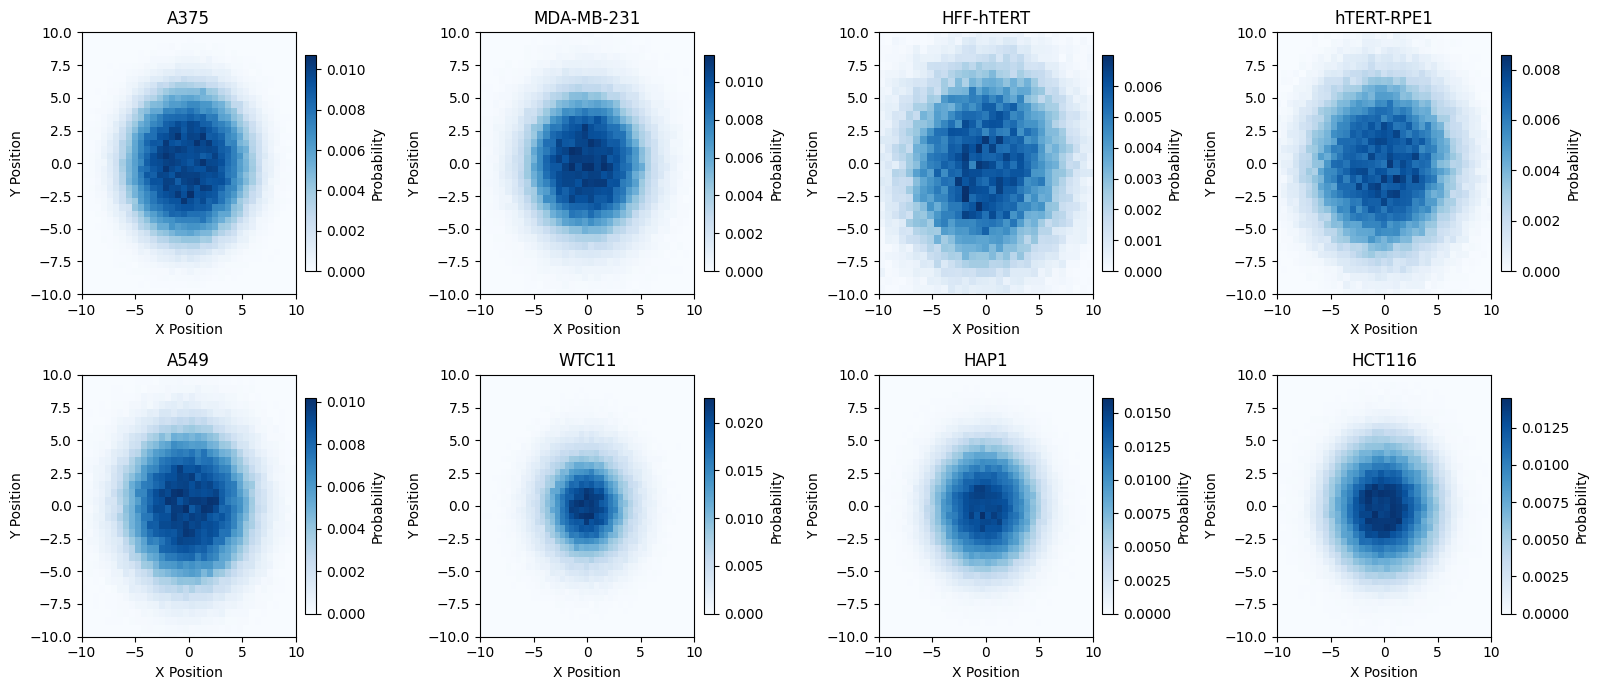

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming your dataframe is called 'eight_cell_lines'
cell_types = eight_cell_lines['cell_type'].unique()

# Create a figure with a 2 by 4 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(16, 7))  # Adjust the figsize as needed
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for i, cell in enumerate(cell_types):
    # Select the current axis for plotting
    ax = axes[i]
    
    # Filter data for the current cell type
    eight_cell_lines1 = eight_cell_lines.loc[eight_cell_lines['cell_type'] == cell]

    # Ensure non-empty valid data
    valid_data = eight_cell_lines1['nuc_centered_spots'].dropna()
    if valid_data.empty:
        ax.set_title(f'{cell} (No Data)')
        ax.axis('off')  # Turn off the axis if no valid data is present
        continue

    # Stack the non-empty valid data
    data = np.vstack(valid_data.values)

    # Split the data into x and y coordinates
    x = data[:, 0]
    y = data[:, 1]

    # Remove NaN values from the x and y arrays
    valid_mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[valid_mask]
    y = y[valid_mask]

    # Check for empty x or y after filtering
    if len(x) == 0 or len(y) == 0:
        ax.set_title(f'{cell} (No Valid Data)')
        ax.axis('off')  # Turn off the axis if no valid data is present
        continue

    # Create a 2D histogram
    h = ax.hist2d(x, y, bins=50, cmap='Blues', density=True)

    # Add a colorbar to show the intensity scale
    cb = fig.colorbar(h[3], ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cb.set_label('Probability')
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    # Set labels and title
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title(f'{cell}')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


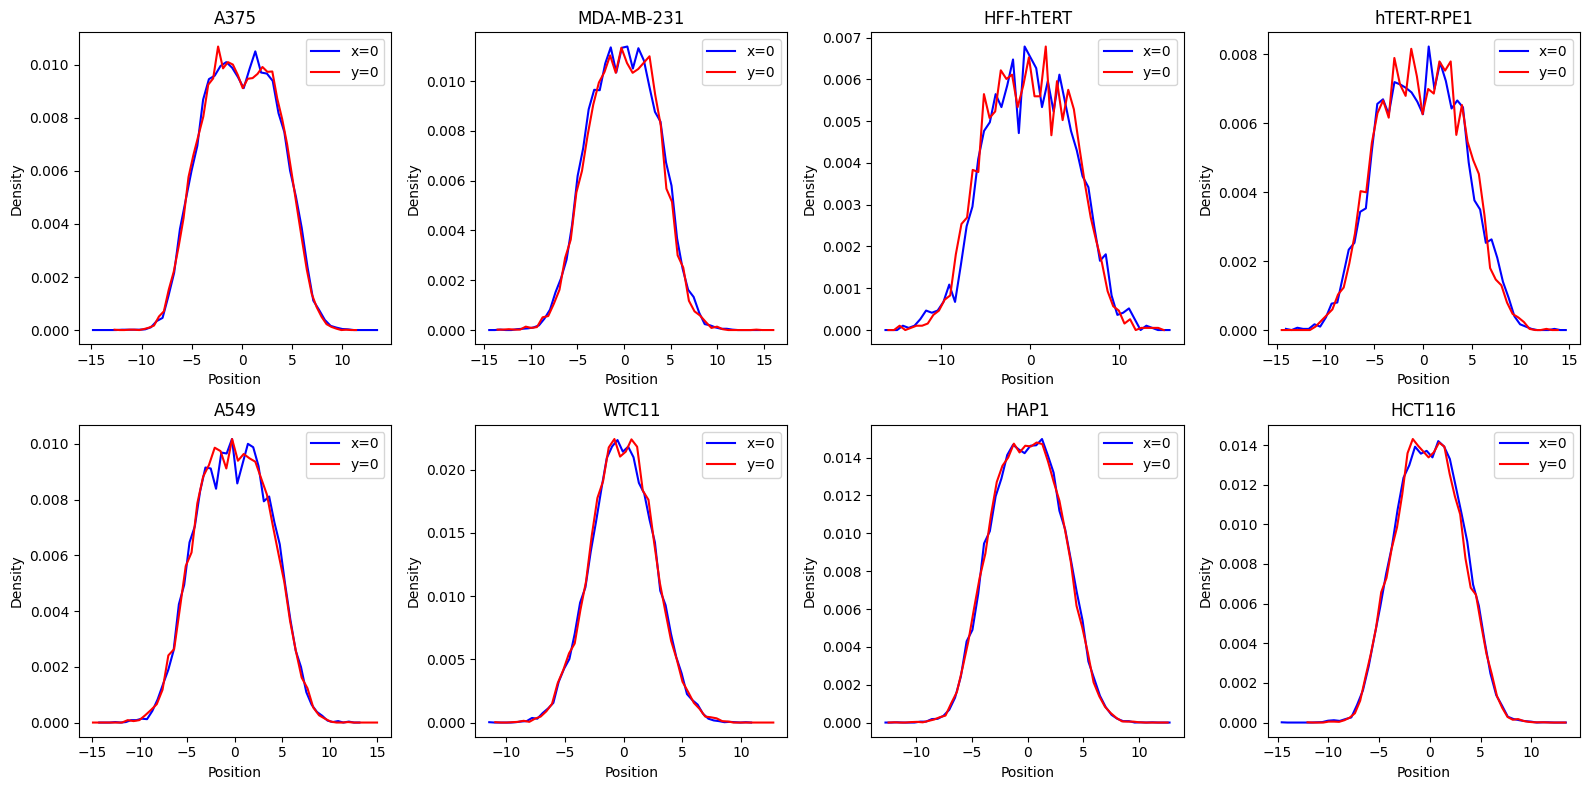

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming your dataframe is called 'eight_cell_lines'
cell_types = eight_cell_lines['cell_type'].unique()

# Create a figure with a 2 by 4 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # Adjust the figsize as needed
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for i, cell in enumerate(cell_types):
    # Select the current axis for plotting
    ax = axes[i]
    
    # Filter data for the current cell type
    eight_cell_lines1 = eight_cell_lines.loc[eight_cell_lines['cell_type'] == cell]

    # Ensure non-empty valid data
    valid_data = eight_cell_lines1['nuc_centered_spots'].dropna()
    if valid_data.empty:
        ax.set_title(f'{cell} (No Data)')
        ax.axis('off')  # Turn off the axis if no valid data is present
        continue

    # Stack the non-empty valid data
    data = np.vstack(valid_data.values)

    # Split the data into x and y coordinates
    x = data[:, 0]
    y = data[:, 1]

    # Remove NaN values from the x and y arrays
    valid_mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[valid_mask]
    y = y[valid_mask]

    # Check for empty x or y after filtering
    if len(x) == 0 or len(y) == 0:
        ax.set_title(f'{cell} (No Valid Data)')
        ax.axis('off')  # Turn off the axis if no valid data is present
        continue

    # Create a 2D histogram
    h, xedges, yedges = np.histogram2d(x, y, bins=50, density=True)

    # Get the centers of the bins
    x_bin_centers = (xedges[:-1] + xedges[1:]) / 2
    y_bin_centers = (yedges[:-1] + yedges[1:]) / 2

    # Extract the line plot for x=0 and y=0
    x_center_idx = np.abs(x_bin_centers).argmin()  # Index of bin closest to x=0
    y_center_idx = np.abs(y_bin_centers).argmin()  # Index of bin closest to y=0

    x_line = h[:, y_center_idx]  # Line for x = 0
    y_line = h[x_center_idx, :]  # Line for y = 0

    # Plot the line plots on the current axis
    ax.plot(x_bin_centers, x_line, 'b-', label='x=0')  # Blue line for x = 0
    ax.plot(y_bin_centers, y_line, 'r-', label='y=0')  # Red line for y = 0

    # Set labels and title
    ax.set_xlabel('Position')
    ax.set_ylabel('Density')
    ax.set_title(f'{cell}')

    # Add legend
    ax.legend()

# Turn off unused axes if there are any
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [66]:
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed

# Initial parameters for MCMC
initial_r0 = 5.0
initial_sigma = 5
n_iterations = 1000
T_burnin = 100

# Proposal distribution standard deviations for r0 and sigma
eta_r0 = 0.1
eta_sigma = 0.1

# Priors for r0 and sigma
mu_r0 = 5.0  # Prior mean for r0
tau_r0 = 5  # Prior std for r0
mu_sigma = 5  # Prior mean for sigma
tau_sigma = 5.0  # Prior std for sigma

# Function to compute radial distances for a cell's centromere data
def compute_radial_distances(xy_coords):
    return np.sqrt(np.sum(xy_coords**2, axis=1))

# Likelihood function for radial Gaussian
def log_likelihood(r0, sigma, radial_distances):
    likelihood = -0.5 * np.sum((radial_distances - r0)**2 / sigma**2) - len(radial_distances) * np.log(sigma)
    return likelihood

# Prior for r0
def log_prior_r0(r0):
    return -0.5 * (r0 - mu_r0)**2 / tau_r0**2

# Prior for sigma
def log_prior_sigma(sigma):
    return -0.5 * (sigma - mu_sigma)**2 / tau_sigma**2 if sigma > 0 else -np.inf

# MCMC function for a single cell line
def run_mcmc_for_cell_line(cell_type_data, initial_r0, initial_sigma, eta_r0, eta_sigma, n_iterations, T_burnin):
    # Initialize current values of r0 and sigma
    r0_current = initial_r0
    sigma_current = initial_sigma
    
    r0_samples = []
    sigma_samples = []

    # MCMC loop
    for t in range(n_iterations):
        # Propose new values for r0 and sigma
        r0_new = r0_current + np.random.normal(0, eta_r0)
        sigma_new = sigma_current + np.random.normal(0, eta_sigma)
        
        # Check for positive sigma
        if sigma_new <= 0:
            sigma_new = sigma_current
        
        log_posterior_current = 0
        log_posterior_new = 0

        # Loop through each cell's data in the current cell type
        for xy_coords in cell_type_data:
            radial_distances = compute_radial_distances(np.array(xy_coords))
            
            # Compute log-likelihood for current and new r0 and sigma
            log_likelihood_current = log_likelihood(r0_current, sigma_current, radial_distances)
            log_likelihood_new = log_likelihood(r0_new, sigma_new, radial_distances)
            
            log_posterior_current += log_likelihood_current
            log_posterior_new += log_likelihood_new

        # Add prior contributions (Gaussian priors for r0 and sigma)
        log_posterior_current += log_prior_r0(r0_current) + log_prior_sigma(sigma_current)
        log_posterior_new += log_prior_r0(r0_new) + log_prior_sigma(sigma_new)

        # Calculate acceptance ratio
        alpha = np.exp(log_posterior_new - log_posterior_current)

        # Accept or reject the new values
        if np.random.uniform(0, 1) < alpha:
            r0_current = r0_new
            sigma_current = sigma_new

        # Store the samples after burn-in
        if t >= T_burnin:
            r0_samples.append(r0_current)
            sigma_samples.append(sigma_current)

    # Convert samples to arrays
    r0_samples = np.array(r0_samples)
    sigma_samples = np.array(sigma_samples)

    # Summary statistics
    r0_mean = np.mean(r0_samples)
    sigma_mean = np.mean(sigma_samples)

    return r0_mean, sigma_mean

# Function to run MCMC for each cell line in parallel
def run_mcmc_for_all_cell_lines(eight_cell_lines):
    cell_line_groups = eight_cell_lines.groupby('cell_type')['M6_nuc_centered_coords']
    results = {}

    with ThreadPoolExecutor() as executor:
        future_to_cell_type = {executor.submit(run_mcmc_for_cell_line, cell_type_data, initial_r0, initial_sigma, eta_r0, eta_sigma, n_iterations, T_burnin): cell_type
                               for cell_type, cell_type_data in cell_line_groups}

        for future in as_completed(future_to_cell_type):
            cell_type = future_to_cell_type[future]
            try:
                r0_mean, sigma_mean = future.result()
                results[cell_type] = {'r0': r0_mean, 'sigma': sigma_mean}
            except Exception as exc:
                print(f'{cell_type} generated an exception: {exc}')
    
    return results

# Run MCMC for all cell lines and store the results
cell_line_results = run_mcmc_for_all_cell_lines(eight_cell_lines)
# Print the results
print(cell_line_results)


<ipython-input-66-ce374644b1b4>:76: RuntimeWarning: overflow encountered in exp
  alpha = np.exp(log_posterior_new - log_posterior_current)


{'hTERT-RPE1': {'r0': 4.330979101901479, 'sigma': 2.169254396087391}, 'A549': {'r0': 3.7898383612656663, 'sigma': 1.9203283899614791}, 'WTC11': {'r0': 3.0299575012822713, 'sigma': 1.5932917118818297}, 'HFF-hTERT': {'r0': 4.717523170414249, 'sigma': 2.4679284797720364}, 'A375': {'r0': 3.799969955478907, 'sigma': 1.824291221754095}, 'HCT116': {'r0': 3.361741595125754, 'sigma': 1.6908594854278585}, 'HAP1': {'r0': 3.1890477028033093, 'sigma': 1.6146968432448714}, 'MDA-MB-231': {'r0': 3.551256042238339, 'sigma': 1.8464865429832913}}


In [64]:
# cell_line_groups = eight_cell_lines.groupby('cell_type')['radial_gaussian_spot_generator']['coords']

eight_cell_lines['M6_nuc_centered_coords'] = eight_cell_lines.apply( lambda x: x.radial_gaussian_spot_generator['coords'] -  0.108 * np.array([128, 128]), axis=1)


In [67]:
# Load the results from the pickle file
with open('/data/krishnendu/ripley_paper/8cell_lines/bayesian_cell_line_results.pkl', 'rb') as f:
    loaded_results = pickle.load(f)

print(loaded_results)

{'hTERT-RPE1': {'r0': 4.992992498205595, 'sigma': 2.250363855247144}, 'A549': {'r0': 4.407244154709491, 'sigma': 2.0191494413771895}, 'WTC11': {'r0': 3.2427240592476916, 'sigma': 1.6672761444366606}, 'HFF-hTERT': {'r0': 5.60586767904576, 'sigma': 2.6195631432616997}, 'A375': {'r0': 4.1936079081006365, 'sigma': 1.8192619458547152}, 'HCT116': {'r0': 3.7582119404913548, 'sigma': 1.7679742484768413}, 'HAP1': {'r0': 3.6324948005360773, 'sigma': 1.7056746878233031}, 'MDA-MB-231': {'r0': 4.189804595241571, 'sigma': 1.9921708875664303}}


In [ ]:
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.stats import norm

# Initial parameters for MCMC
initial_r0 = 5.0
initial_sigma = 5.0
n_iterations = 1000
T_burnin = 100

# Proposal distribution standard deviations for r0 and sigma
eta_r0 = 0.1
eta_sigma = 0.1

# Priors for r0 and sigma
mu_r0 = 5.0  # Prior mean for r0
tau_r0 = 5.0  # Prior std for r0
mu_sigma = 5.0  # Prior mean for sigma
tau_sigma = 5.0  # Prior std for sigma

# Function to compute pairwise distances for a cell's centromere data
def compute_pairwise_distances(xy_coords):
    # Compute pairwise distances between all points
    pairwise_distances = np.sqrt(np.sum((xy_coords[:, np.newaxis, :] - xy_coords[np.newaxis, :, :])**2, axis=-1))
    # Return only the upper triangle without the diagonal (unique distances)
    return pairwise_distances[np.triu_indices_from(pairwise_distances, k=1)]

# Radial Gaussian distribution
def P_r(r, r0, sigma):
    return norm.pdf(r, loc=r0, scale=sigma)

# Define the Heaviside function
def H(x):
    return 1.0 if x >= 0 else 0.0

# Monte Carlo-based P(d | r0, sigma)
def P_d_given_r0_sigma_monte_carlo(d, r0, sigma, num_samples=1000):
    # Sample r1 and r2 from the radial Gaussian distribution
    r1_samples = np.random.normal(loc=r0, scale=sigma, size=num_samples)
    r2_samples = np.random.normal(loc=r0, scale=sigma, size=num_samples)
    
    # Ensure r1 and r2 are positive
    valid = (r1_samples > 0) & (r2_samples > 0)
    r1_samples = r1_samples[valid]
    r2_samples = r2_samples[valid]
    
    # Compute the argument for the Heaviside function
    argument = (r1_samples**2 + r2_samples**2 - d**2) / (2 * r1_samples * r2_samples)
    
    # Apply the Heaviside function
    H_vals = np.where(np.abs(argument) <= 1, 1.0, 0.0)
    
    # Compute the integrand
    integrand_vals = (P_r(r1_samples, r0, sigma) * P_r(r2_samples, r0, sigma)) / (2 * r1_samples * r2_samples) * H_vals
    
    # Estimate the integral using the average value multiplied by the sample space
    # Since we're sampling from P(r1 | r0, sigma) and P(r2 | r0, sigma), the expectation is already scaled
    # So, the estimate is just the mean of integrand_vals
    integral_estimate = np.mean(integrand_vals)
    
    return (1 / (2 * np.pi**2)) * integral_estimate

# Log-likelihood function using Monte Carlo-based P(d | r0, sigma)
def log_likelihood_pairwise_monte_carlo(r0, sigma, pairwise_distances, num_samples=1000):
    log_likelihood = 0.0
    for d in pairwise_distances:
        p_d = P_d_given_r0_sigma_monte_carlo(d, r0, sigma, num_samples)
        if p_d > 0:
            log_likelihood += np.log(p_d)
        else:
            # Assign a very low probability to avoid -inf
            log_likelihood += -1e10  # or another sufficiently low value
    return log_likelihood

# Prior for r0
def log_prior_r0(r0):
    return -0.5 * ((r0 - mu_r0) / tau_r0)**2

# Prior for sigma
def log_prior_sigma(sigma):
    return -0.5 * ((sigma - mu_sigma) / tau_sigma)**2 if sigma > 0 else -np.inf

# MCMC function for a single cell line using pairwise distances and Monte Carlo-based likelihood
def run_mcmc_for_cell_line(cell_type_data, initial_r0, initial_sigma, eta_r0, eta_sigma, n_iterations, T_burnin, num_samples=1000):
    # Initialize current values of r0 and sigma
    r0_current = initial_r0
    sigma_current = initial_sigma
    
    r0_samples = []
    sigma_samples = []
    
    # Precompute all pairwise distances for efficiency
    all_pairwise_distances = []
    for xy_coords in cell_type_data:
        xy_coords = np.array(xy_coords)
        pairwise_distances = compute_pairwise_distances(xy_coords)
        all_pairwise_distances.append(pairwise_distances)
    
    # MCMC loop
    for t in range(n_iterations):
        # Propose new values for r0 and sigma
        r0_new = r0_current + np.random.normal(0, eta_r0)
        sigma_new = sigma_current + np.random.normal(0, eta_sigma)
        
        # Check for positive sigma
        if sigma_new <= 0:
            sigma_new = sigma_current
        
        # Compute log-posterior for current and new parameters
        log_posterior_current = 0.0
        log_posterior_new = 0.0
        
        # Compute log-likelihoods
        for pairwise_distances in all_pairwise_distances:
            log_likelihood_current = log_likelihood_pairwise_monte_carlo(r0_current, sigma_current, pairwise_distances, num_samples)
            log_likelihood_new = log_likelihood_pairwise_monte_carlo(r0_new, sigma_new, pairwise_distances, num_samples)
            
            log_posterior_current += log_likelihood_current
            log_posterior_new += log_likelihood_new
        
        # Add prior contributions (Gaussian priors for r0 and sigma)
        log_posterior_current += log_prior_r0(r0_current) + log_prior_sigma(sigma_current)
        log_posterior_new += log_prior_r0(r0_new) + log_prior_sigma(sigma_new)
        
        # Calculate acceptance ratio
        alpha = np.exp(log_posterior_new - log_posterior_current)
        
        # Accept or reject the new values
        if np.random.uniform(0, 1) < alpha:
            r0_current = r0_new
            sigma_current = sigma_new
        
        # Store the samples after burn-in
        if t >= T_burnin:
            r0_samples.append(r0_current)
            sigma_samples.append(sigma_current)
    
    # Convert samples to arrays
    r0_samples = np.array(r0_samples)
    sigma_samples = np.array(sigma_samples)
    
    # Summary statistics
    r0_mean = np.mean(r0_samples)
    sigma_mean = np.mean(sigma_samples)
    
    return r0_mean, sigma_mean

# Function to run MCMC for each cell line in parallel
def run_mcmc_for_all_cell_lines(eight_cell_lines, num_samples=1000):
    cell_line_groups = eight_cell_lines.groupby('cell_type')['nuc_centered_spots']
    results = {}
    
    with ThreadPoolExecutor() as executor:
        future_to_cell_type = {
            executor.submit(
                run_mcmc_for_cell_line,
                cell_type_data,
                initial_r0,
                initial_sigma,
                eta_r0,
                eta_sigma,
                n_iterations,
                T_burnin,
                num_samples
            ): cell_type
            for cell_type, cell_type_data in cell_line_groups
        }
        
        for future in as_completed(future_to_cell_type):
            cell_type = future_to_cell_type[future]
            try:
                r0_mean, sigma_mean = future.result()
                results[cell_type] = {'r0': r0_mean, 'sigma': sigma_mean}
            except Exception as exc:
                print(f'{cell_type} generated an exception: {exc}')
    
    return results

# Example usage:
# Assuming `eight_cell_lines` is your DataFrame with 'cell_type' and 'nuc_centered_spots' columns
cell_line_results = run_mcmc_for_all_cell_lines(eight_cell_lines, num_samples=1000)
print(cell_line_results)


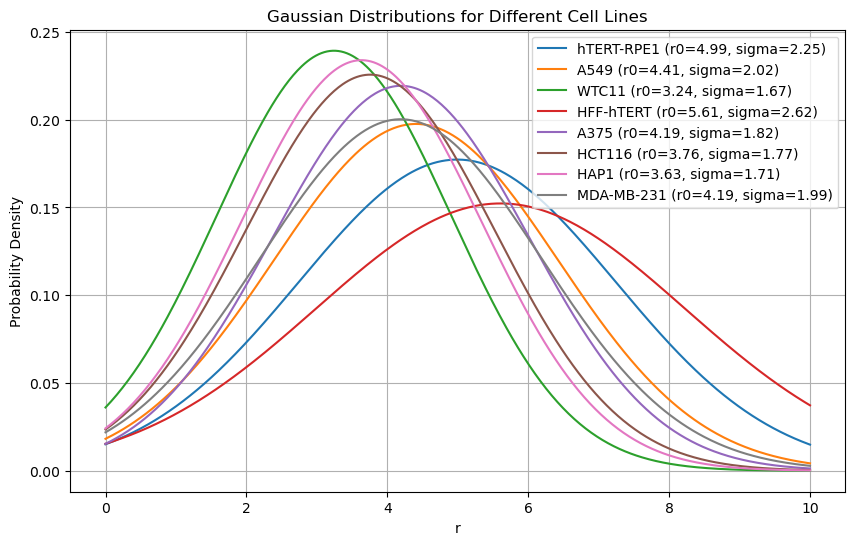

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Gaussian parameters for each cell line
gaussians = loaded_results

# Create a range of r values to plot the distributions
r_values = np.linspace(0, 10, 500)

# Function to calculate the Gaussian distribution
def gaussian(r, r0, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-(r - r0) ** 2 / (2 * sigma ** 2))

# Plot each Gaussian distribution
plt.figure(figsize=(10, 6))

for cell_line, params in gaussians.items():
    r0 = params['r0']
    sigma = params['sigma']
    
    # Calculate the Gaussian values for this cell line
    pdf_values = gaussian(r_values, r0, sigma)
    
    # Plot the Gaussian curve
    plt.plot(r_values, pdf_values, label=f'{cell_line} (r0={r0:.2f}, sigma={sigma:.2f})')

# Add plot details
plt.title('Gaussian Distributions for Different Cell Lines')
plt.xlabel('r')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()


A375
25.0


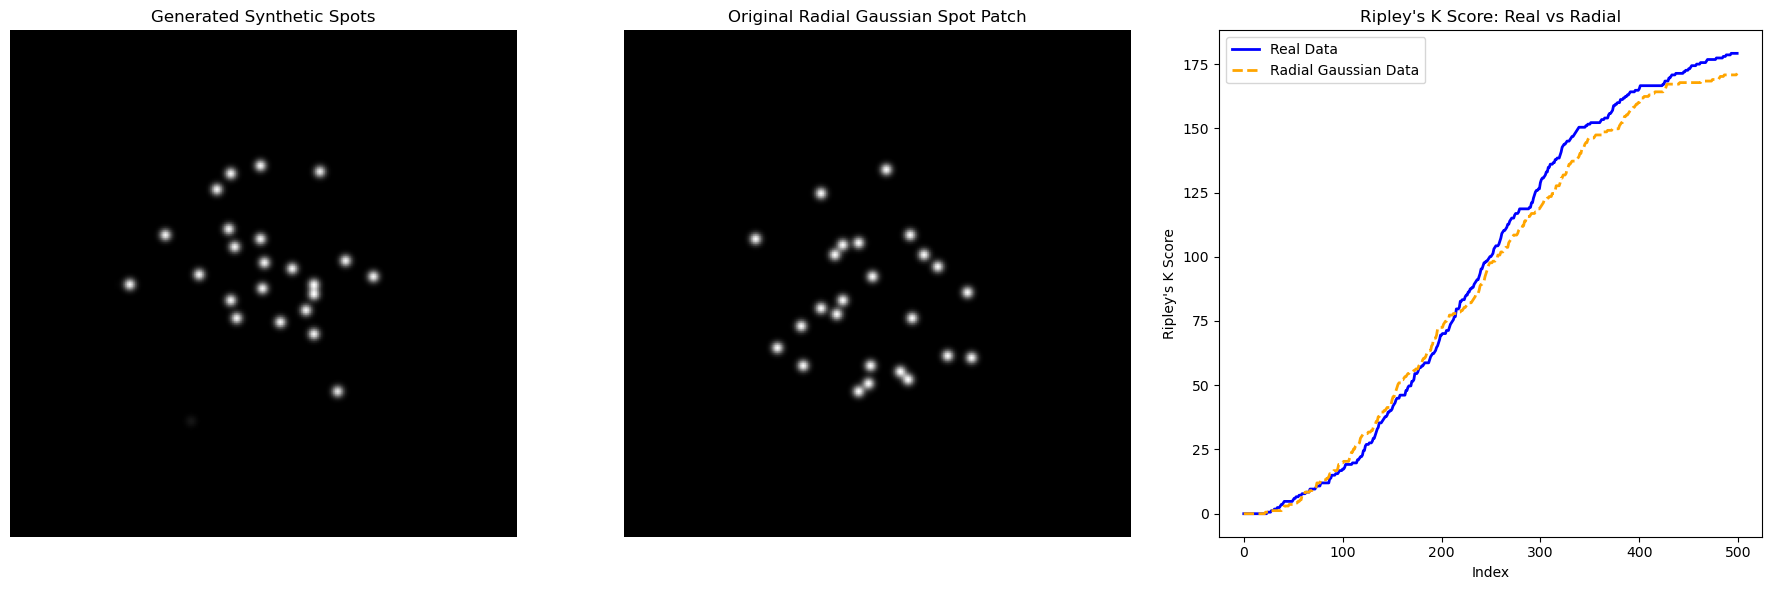

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import gaussian
from skimage import exposure

# Index
ind = 34257
print(eight_cell_lines.cell_type.iloc[ind])
print(eight_cell_lines.spots_number.iloc[ind])

# Create a 1x3 subplot
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# First subplot: Original radial Gaussian spot patch
ax[0].imshow(eight_cell_lines.ripley_based_gaussian_synth_spot_generator.iloc[ind]['patch'], cmap='gray')
ax[0].set_title('Generated Synthetic Spots')
ax[0].axis('off')


# Third subplot: Ripley's K score comparison
real = eight_cell_lines.ripley_no_correction.iloc[ind][0][0]
radial = eight_cell_lines.ripley_based_gaussian_synth_spot_generator.iloc[ind]['metrics']['ripley_k_score'][1]

# Second subplot: Generated synthetic spots
synth_spots = np.zeros((256, 256))

# Offset xy_coor by [128,128] and round the coordinates
xy_coor = eight_cell_lines.nuc_centered_spots.iloc[ind] / 0.108 + np.array([128, 128])
xy_coor = np.round(xy_coor).astype(int)  # Ensure coordinates are integers

# Assign value at the rounded coordinates
synth_spots[xy_coor[:, 0], xy_coor[:, 1]] = 255

# Apply Gaussian smoothing
synth_spots = gaussian(synth_spots, sigma=2).astype("float")

# Rescale intensity and convert to uint8
synth_spots = exposure.rescale_intensity(synth_spots, out_range=(0, 255)).astype("uint8")

# Plot the synthetic spots
ax[1].imshow(synth_spots, cmap='gray')
ax[1].set_title('Original Radial Gaussian Spot Patch')
ax[1].axis('off')



from astropy.stats import RipleysKEstimator
max_radius = 25
Kest = RipleysKEstimator(area=eight_cell_lines.area.iloc[ind])
radii_vals = np.linspace(0, max_radius, 1000)

random_spots = Kest.poisson(radii_vals)

# Plot real vs radial Ripley's K score
ax[2].plot(real[:500], label='Real Data', color='blue', linewidth=2)
ax[2].plot(radial[:500], label='Radial Gaussian Data', color='orange', linestyle='--', linewidth=2)
# ax[2].plot(random_spots[:500], label='Random Spots', color='red', linewidth=2)

ax[2].set_title('Ripley\'s K Score: Real vs Radial')
ax[2].set_xlabel('Index')
ax[2].set_ylabel('Ripley\'s K Score')
ax[2].legend()

# Show the full 1x3 subplot
plt.tight_layout()
plt.show()


# Plot All Metrics

In [24]:
# Define the list of metrics you want to compare
metrics = ['ripley_k_score', 'assortativity', 'modularity', 'morans_i', 'mean_nearest_neighbor_distance', 'dispersion_index']

# Loop through the metrics and methods to create columns for each
for metric in metrics:
    
    if metric == 'ripley_k_score':
        eight_cell_lines[f'M0_{metric}'] = eight_cell_lines.apply(lambda x: x['real_data_spots'].get('metrics', {}).get(metric, [None])[0], axis=1)
        eight_cell_lines[f'M1_{metric}'] = eight_cell_lines.apply(lambda x: x['cell_based_gaussian_synth_spot_generator'].get('metrics', {}).get(metric, [None])[0], axis=1)
        eight_cell_lines[f'M2_{metric}'] = eight_cell_lines.apply(lambda x: x['uniform_spot_generator'].get('metrics', {}).get(metric, [None])[0], axis=1)
        eight_cell_lines[f'M3_{metric}'] = eight_cell_lines.apply(lambda x: x['ripley_based_gaussian_synth_spot_generator'].get('metrics', {}).get(metric, [None])[0], axis=1)
        eight_cell_lines[f'M4_{metric}'] = eight_cell_lines.apply(lambda x: x['radial_gaussian_spot_generator'].get('metrics', {}).get(metric, [None])[0], axis=1)
        eight_cell_lines[f'M5_{metric}'] = eight_cell_lines.apply(lambda x: x['diastance_based_radial_gaussian_spot_generator_3000'].get('metrics', {}).get(metric, [None])[0], axis=1)
    else:
        eight_cell_lines[f'M0_{metric}'] = eight_cell_lines.apply(lambda x: x['real_data_spots'].get('metrics', {}).get(metric, [None]), axis=1)
        eight_cell_lines[f'M1_{metric}'] = eight_cell_lines.apply(lambda x: x['cell_based_gaussian_synth_spot_generator'].get('metrics', {}).get(metric, [None]), axis=1)
        eight_cell_lines[f'M2_{metric}'] = eight_cell_lines.apply(lambda x: x['uniform_spot_generator'].get('metrics', {}).get(metric, [None]), axis=1)
        eight_cell_lines[f'M3_{metric}'] = eight_cell_lines.apply(lambda x: x['ripley_based_gaussian_synth_spot_generator'].get('metrics', {}).get(metric, [None]), axis=1)
        eight_cell_lines[f'M4_{metric}'] = eight_cell_lines.apply(lambda x: x['radial_gaussian_spot_generator'].get('metrics', {}).get(metric, [None]), axis=1)
        eight_cell_lines[f'M5_{metric}'] = eight_cell_lines.apply(lambda x: x['diastance_based_radial_gaussian_spot_generator_3000'].get('metrics', {}).get(metric, [None]), axis=1)
        


KeyError: 'real_data_spots'

In [85]:
eight_cell_lines.ripley_based_gaussian_synth_spot_generator.iloc[0]
metrics = ['radial_distances', 'coords']
import numpy as np
from scipy.spatial.distance import pdist, squareform

def pairwise_distances_upper_triangle(coords):
    pairwise_dists = pdist(coords, metric='euclidean')
    
    dist_matrix = squareform(pairwise_dists)
    upper_triangle = dist_matrix[np.triu_indices(len(coords), k=1)]
    return upper_triangle


# Loop through the metrics and methods to create columns for each
for metric in metrics:
    
    if metric == 'radial_distances':
        eight_cell_lines[f'M0_{metric}'] = eight_cell_lines.apply(lambda x: x['spot_radial_distances'], axis=1)
        eight_cell_lines[f'M1_{metric}'] = eight_cell_lines.apply(lambda x: x['cell_based_gaussian_synth_spot_generator']['radial_distances'], axis=1)
        eight_cell_lines[f'M2_{metric}'] = eight_cell_lines.apply(lambda x: x['uniform_spot_generator']['radial_distances'], axis=1)
        eight_cell_lines[f'M3_{metric}'] = eight_cell_lines.apply(lambda x: x['ripley_based_gaussian_synth_spot_generator']['radial_distances'], axis=1)
        eight_cell_lines[f'M4_{metric}'] = eight_cell_lines.apply(lambda x: x['radial_gaussian_spot_generator']['radial_distances'], axis=1)
        eight_cell_lines[f'M5_{metric}'] = eight_cell_lines.apply(lambda x: x['diastance_based_radial_gaussian_spot_generator_3000']['radial_distances'], axis=1)
    else:
        eight_cell_lines[f'M0_pairwise_distances'] = eight_cell_lines.apply(lambda x: pairwise_distances_upper_triangle(x['real_data_spots'].get(metric, [None])), axis=1)
        eight_cell_lines[f'M1_pairwise_distances'] = eight_cell_lines.apply(lambda x: pairwise_distances_upper_triangle(x['cell_based_gaussian_synth_spot_generator'].get(metric, [None])), axis=1)
        eight_cell_lines[f'M2_pairwise_distances'] = eight_cell_lines.apply(lambda x: pairwise_distances_upper_triangle(x['uniform_spot_generator'].get(metric, [None])), axis=1)
        eight_cell_lines[f'M3_pairwise_distances'] = eight_cell_lines.apply(lambda x: pairwise_distances_upper_triangle(x['ripley_based_gaussian_synth_spot_generator'].get(metric, [None])), axis=1)
        eight_cell_lines[f'M4_pairwise_distances'] = eight_cell_lines.apply(lambda x: pairwise_distances_upper_triangle(x['radial_gaussian_spot_generator'].get(metric, [None])), axis=1)
        eight_cell_lines[f'M5_pairwise_distances'] = eight_cell_lines.apply(lambda x: pairwise_distances_upper_triangle(x['diastance_based_radial_gaussian_spot_generator_3000'].get(metric, [None])), axis=1)
        

In [86]:
for gene in eight_cell_lines.cell_type.unique():
    print(gene, len(eight_cell_lines.loc[eight_cell_lines.cell_type==gene]))

A375 11925
MDA-MB-231 6347
HFF-hTERT 1322
hTERT-RPE1 3641
A549 7786
WTC11 6071
HAP1 18359
HCT116 16116


# Visualization for Single Cell Level

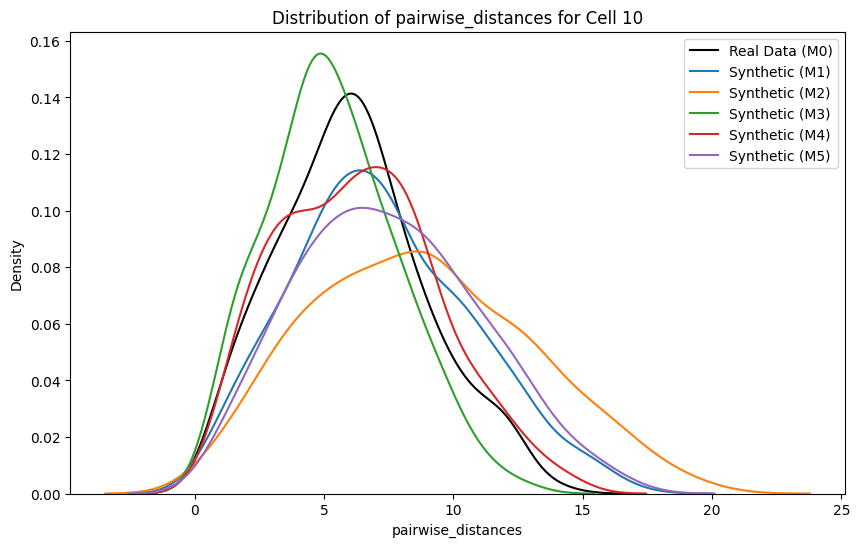

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example of visualizing pairwise distances for a single cell
def plot_single_cell_distributions(cell_data, metric, cell_index):
    plt.figure(figsize=(10, 6))
    
    # Plot the real data (M0)
    sns.kdeplot(cell_data[f'M0_{metric}'].iloc[cell_index], label='Real Data (M0)', color='black')
    
    # Plot each synthetic method (M1 to M6)
    for method in range(1, 6):
        sns.kdeplot(cell_data[f'M{method}_{metric}'].iloc[cell_index], label=f'Synthetic (M{method})')
    
    plt.title(f'Distribution of {metric} for Cell {cell_index}')
    plt.xlabel(metric)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Example usage for a specific cell (index 0)
plot_single_cell_distributions(eight_cell_lines, 'pairwise_distances', cell_index=10)


# Aggregation and Visualization for Cell Line Level

In [27]:
eight_cell_lines['M0_radial_distances'].iloc[0]

array([0.70073172, 0.09631928, 0.18821963, 0.45563801, 0.09036689,
       0.35642179, 0.32328924, 0.30281553, 0.10540222, 0.46068922,
       0.20763056, 0.26097544, 0.48610614, 0.24233775, 0.308455  ,
       0.43154179, 0.67500976, 0.4137931 , 0.70641798])

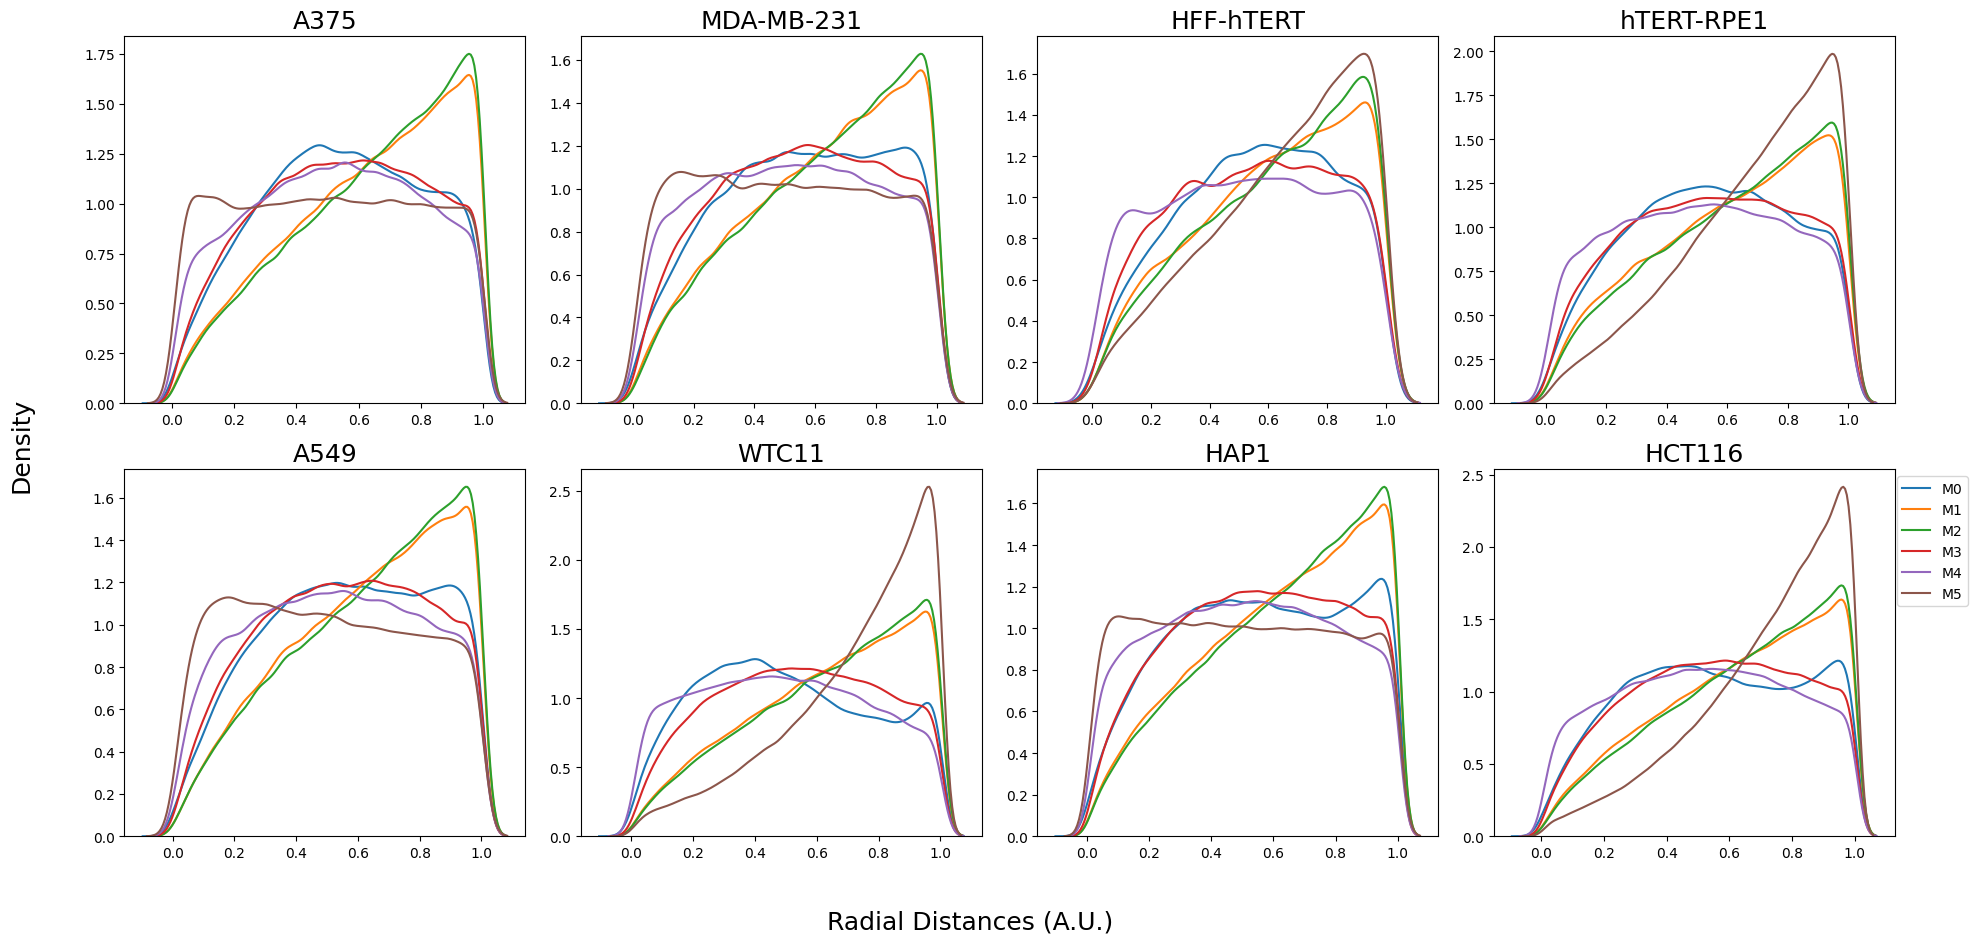

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# eight_cell_lines.loc[eight_cell_lines.spots_number < 47]['M0_radial_distances']
# eight_cell_lines['M0_radial_distances'] = eight_cell_lines.apply(lambda x: x.M0_radial_distances[0][0], axis=1)
# Helper function to format labels
def format_label(text):
    return ' '.join([word.capitalize() for word in text.replace('_', ' ').split()])

# Function to aggregate data by cell line and plot the distributions in a 4x2 grid
def plot_cell_line_distributions(cell_data, metric):
    cell_types = cell_data['cell_type'].unique()  # Get unique cell lines
    num_cell_types = len(cell_types)  # Number of unique cell lines
    
    # Create a 4x2 grid for plotting with the specified figure size
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    # Flatten the axes array for easy indexing
    axes = axes.flatten()
    
    # Loop through each cell type and plot its distribution on a separate subplot
    for i, cell_type in enumerate(cell_types):
        ax = axes[i]
        for method in ['M0'] + [f'M{m}' for m in range(1, 6)]:
            # Get the data for the current cell type
            data_series = cell_data[cell_data['cell_type'] == cell_type][f'{method}_{metric}']
            
            # Flatten each array in the series, ignoring invalid or empty arrays
            flattened_data = [
                np.ravel(arr) for arr in data_series.dropna() if isinstance(arr, (list, np.ndarray)) and arr.size > 0
            ]
            
            if not flattened_data:
                continue  # Skip if no valid data
            
            # Concatenate the flattened data
            data_concat = np.concatenate(flattened_data)
            
            # Plot the distribution using seaborn's kdeplot
            sns.kdeplot(data_concat, label=format_label(method), ax=ax)
        
        # Set title and labels for each subplot
        ax.set_title(f'{cell_type}', fontsize=18)
        ax.set_xlabel('')
        ax.set_ylabel('')
    
    # Add legend to the last subplot
    axes[-1].legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    
    # Set the main title for the figure
    fig.supxlabel('Radial Distances (A.U.)', fontsize=18)
    fig.supylabel('Density', fontsize=18)
    # Adjust layout to avoid overlap, making space for the title
    plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
    plt.show()

# Example usage for radial distances
plot_cell_line_distributions(eight_cell_lines.loc[eight_cell_lines.spots_number < 47], 'radial_distances')


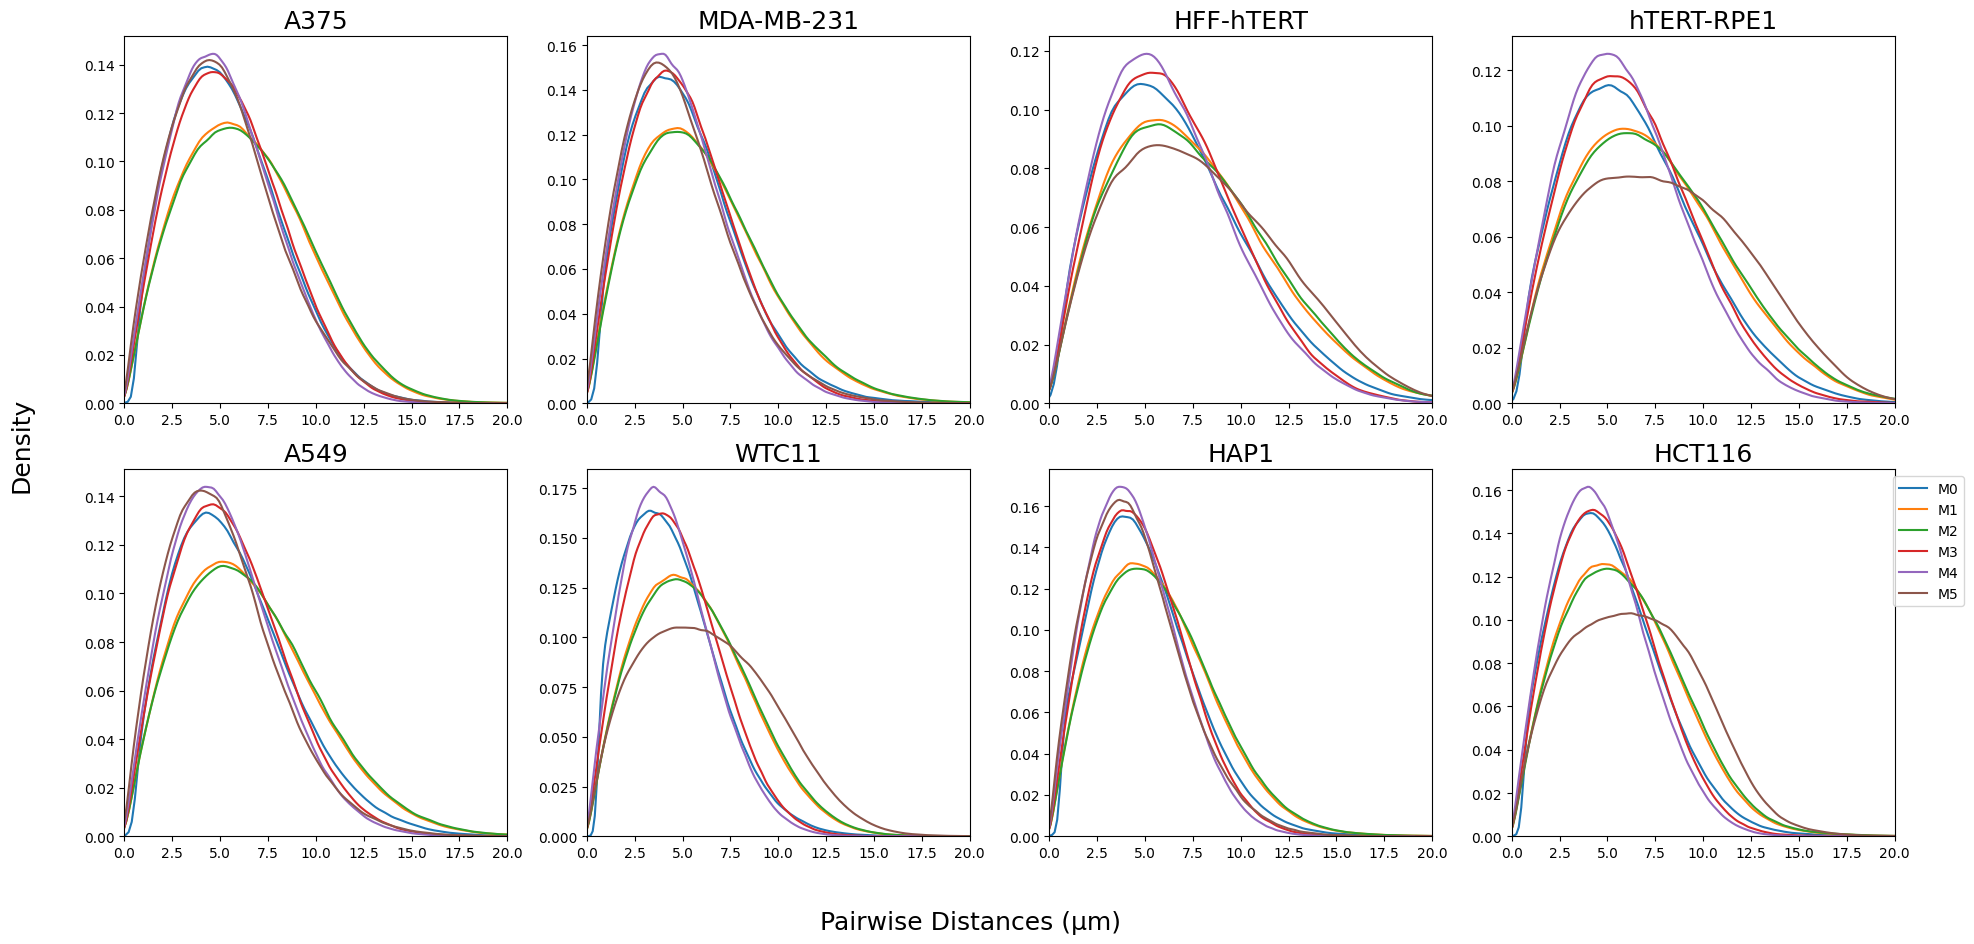

In [29]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Helper function to format labels
def format_label(text):
    return ' '.join([word.capitalize() for word in text.replace('_', ' ').split()])

# Function to aggregate data by cell line and plot the distributions in a 2x4 grid
def plot_cell_line_distributions(cell_data, metric):
    cell_types = cell_data['cell_type'].unique()  # Get unique cell lines
    num_cell_types = len(cell_types)  # Number of unique cell lines
    
    # Create a 2x4 grid for plotting with the specified figure size
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    # Flatten the axes array for easy indexing
    axes = axes.flatten()
    
    # Loop through each cell type and plot its distribution on a separate subplot
    for i, cell_type in enumerate(cell_types):
        ax = axes[i]
        for method in ['M0'] + [f'M{m}' for m in range(1, 6)]:
            # Get the data for the current cell type
            data_concat = np.concatenate(cell_data[cell_data['cell_type'] == cell_type][f'{method}_{metric}'].apply(np.hstack).values)
            
            # Plot the distribution using seaborn's kdeplot
            sns.kdeplot(data_concat, label=format_label(method), ax=ax)
        
        # Set title, labels, and x-axis limits for each subplot
        ax.set_title(f'{cell_type}', fontsize=18)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xlim(0, 20)  # Limit x-axis range to 0-20
    
    # Hide any unused subplots
    for j in range(len(cell_types), len(axes)):
        axes[j].axis('off')
    
    # Add legend to the last active subplot
    axes[len(cell_types) - 1].legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    
    # Set the main title for the figure
    # fig.suptitle("Pairwise Distance Distribution For Various Cell Lines", fontsize=16)
    fig.supxlabel('Pairwise Distances' + ' (\u03BCm)', fontsize=18)
    fig.supylabel('Density', fontsize=18)
    # Adjust layout to avoid overlap, making space for the title
    plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
    plt.show()

# Example usage for pairwise distances
plot_cell_line_distributions(eight_cell_lines.loc[eight_cell_lines.spots_number < 47], 'pairwise_distances')


In [19]:
from scipy.stats import ks_2samp, wasserstein_distance
from sklearn.metrics import mean_squared_error
import scipy.stats as stats

metrics = ['pairwise_distances', 'radial_distances']
filtered_cells_df = eight_cell_lines.loc[eight_cell_lines.spots_number<47]
for metric in metrics:
    for cell_line in filtered_cells_df.cell_type.unique():
        
        cell_data = filtered_cells_df.loc[filtered_cells_df.cell_type==cell_line]
        real_data = np.concatenate(cell_data[f'M0_{metric}'].apply(np.hstack).values)
        real_data = real_data[~np.isnan(real_data)]
        
        for method in range(1,6):

            synthetic_data = np.concatenate(cell_data[f'M{method}_{metric}'].apply(np.hstack).values)
            synthetic_data = synthetic_data[~np.isnan(synthetic_data)]  # Remove NaN values
            
            # Resample to match sizes
            if len(real_data) > len(synthetic_data):
                real_data_resampled = np.random.choice(real_data, size=len(synthetic_data), replace=False)
                synthetic_data_resampled = synthetic_data
            else:
                synthetic_data_resampled = np.random.choice(synthetic_data, size=len(real_data), replace=False)
                real_data_resampled = real_data
            
            if len(real_data_resampled) > 0 and len(synthetic_data_resampled) > 0:
               
                # Calculate Wasserstein Distance
                wasserstein_results = wasserstein_distance(real_data_resampled, synthetic_data_resampled)

                real_pdf, real_bins = np.histogram(real_data_resampled, bins=100, density=True)
                synthetic_pdf, _ = np.histogram(synthetic_data_resampled, bins=real_bins, density=True)
                
                # Step 2: Normalize the PDFs
                real_pdf = real_pdf / np.sum(real_pdf)
                synthetic_pdf = synthetic_pdf / np.sum(synthetic_pdf)
                
                # Step 3: Calculate Normalized Mean Squared Error (MSE)
                mse = mean_squared_error(real_pdf, synthetic_pdf)
                normalized_mse = mse / np.var(real_pdf)  # Normalize by variance of real PDF


                ks_stat, p_value = ks_2samp(real_data_resampled, synthetic_data_resampled)
                
            else:
                wasserstein_results = np.nan
                normalized_mse = np.nan
                ks_stat = np.nan

            print(cell_line,f'M{method}_{metric}')
            print("wasserstein_results: ", wasserstein_results)
            print("normalized_mse: ", mse)
            print("ks_stat: ", ks_stat)
        

A375 M1_pairwise_distances
wasserstein_results:  0.9069961133411651
normalized_mse:  1.699497631508939e-05
ks_stat:  0.12527308806721127
A375 M2_pairwise_distances
wasserstein_results:  0.9817833181527915
normalized_mse:  1.9417997270991313e-05
ks_stat:  0.13384214877078737
A375 M3_pairwise_distances
wasserstein_results:  0.09431823914205001
normalized_mse:  1.1659378643332948e-06
ks_stat:  0.017127577466333144
A375 M4_pairwise_distances
wasserstein_results:  0.1954448015093883
normalized_mse:  1.0056267837362008e-06
ks_stat:  0.024486193763891606
A375 M5_pairwise_distances
wasserstein_results:  0.18032486464075292
normalized_mse:  1.5774103336344347e-06
ks_stat:  0.026620814582691943
MDA-MB-231 M1_pairwise_distances
wasserstein_results:  0.7817113928865812
normalized_mse:  1.1640966625541395e-05
ks_stat:  0.10450029542766448
MDA-MB-231 M2_pairwise_distances
wasserstein_results:  0.8481714024174202
normalized_mse:  1.3162303947582295e-05
ks_stat:  0.11161478338990871
MDA-MB-231 M3_pair

In [20]:
# Adjusted Code to Save Multiple Metrics
from scipy.stats import ks_2samp, wasserstein_distance
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Initialize placeholder DataFrame for results
metrics = ['pairwise_distances', 'radial_distances']
methods = [f'M{method}' for method in range(1, 6)]
cell_lines = ['A375', 'MDA-MB-231', 'HFF-hTERT', 'hTERT-RPE1', 'A549', 'WTC11', 'HAP1', 'HCT116']

# Create a multi-index DataFrame
index = pd.MultiIndex.from_product([cell_lines, metrics], names=['Cell Line', 'Metric'])
columns = pd.MultiIndex.from_product([methods, ['Wasserstein Distance', 'Normalized MSE', 'KS statistic']],
                                      names=['Method', 'Metric Type'])
results_df = pd.DataFrame(index=index, columns=columns)

# Compute metrics and populate results DataFrame
for metric in metrics:
    for cell_line in filtered_cells_df.cell_type.unique():
        
        cell_data = filtered_cells_df.loc[filtered_cells_df.cell_type == cell_line]
        real_data = np.concatenate(cell_data[f'M0_{metric}'].apply(np.hstack).values)
        real_data = real_data[~np.isnan(real_data)]
        
        for method in range(1, 6):

            synthetic_data = np.concatenate(cell_data[f'M{method}_{metric}'].apply(np.hstack).values)
            synthetic_data = synthetic_data[~np.isnan(synthetic_data)]  # Remove NaN values
            
            # Resample to match sizes
            if len(real_data) > len(synthetic_data):
                real_data_resampled = np.random.choice(real_data, size=len(synthetic_data), replace=False)
                synthetic_data_resampled = synthetic_data
            else:
                synthetic_data_resampled = np.random.choice(synthetic_data, size=len(real_data), replace=False)
                real_data_resampled = real_data
            
            if len(real_data_resampled) > 0 and len(synthetic_data_resampled) > 0:
               
                # Calculate Wasserstein Distance
                wasserstein_results = wasserstein_distance(real_data_resampled, synthetic_data_resampled)

                real_pdf, real_bins = np.histogram(real_data_resampled, bins=100, density=True)
                synthetic_pdf, _ = np.histogram(synthetic_data_resampled, bins=real_bins, density=True)
                
                # Step 2: Normalize the PDFs
                real_pdf = real_pdf / np.sum(real_pdf)
                synthetic_pdf = synthetic_pdf / np.sum(synthetic_pdf)
                
                # Step 3: Calculate Normalized Mean Squared Error (MSE)
                mse = mean_squared_error(real_pdf, synthetic_pdf)
                normalized_mse = mse / np.var(real_pdf)  # Normalize by variance of real PDF

                ks_stat, p_value = ks_2samp(real_data_resampled, synthetic_data_resampled)
                
            else:
                wasserstein_results = np.nan
                normalized_mse = np.nan
                ks_stat = np.nan

            # Store results in the DataFrame
            results_df.loc[(cell_line, metric), (f"M{method}", 'Wasserstein Distance')] = round(wasserstein_results, 2)
            results_df.loc[(cell_line, metric), (f"M{method}", 'Normalized MSE')] = round(normalized_mse, 2)
            results_df.loc[(cell_line, metric), (f"M{method}", 'KS statistic')] = round(ks_stat, 2)



In [104]:
# Flatten the MultiIndex for columns and rows before melting
results_df_reset = results_df.copy()
results_df_reset.columns = ['_'.join(col).strip() for col in results_df_reset.columns.values]
results_df_reset = results_df_reset.reset_index()  # Flatten MultiIndex rows if present

# Melt the DataFrame for easier plotting
melted_df = results_df_reset.melt(
    id_vars=['Cell Line', 'Metric'],  # Adjust these to match your flattened DataFrame
    var_name='Method_MetricType',
    value_name='Value'
)

# Split 'Method_MetricType' into separate columns
melted_df[['Method', 'Metric Type']] = melted_df['Method_MetricType'].str.rsplit('_', n=1, expand=True)

# Drop the combined column
melted_df = melted_df.drop(columns=['Method_MetricType'])

# Now proceed with the plotting as before


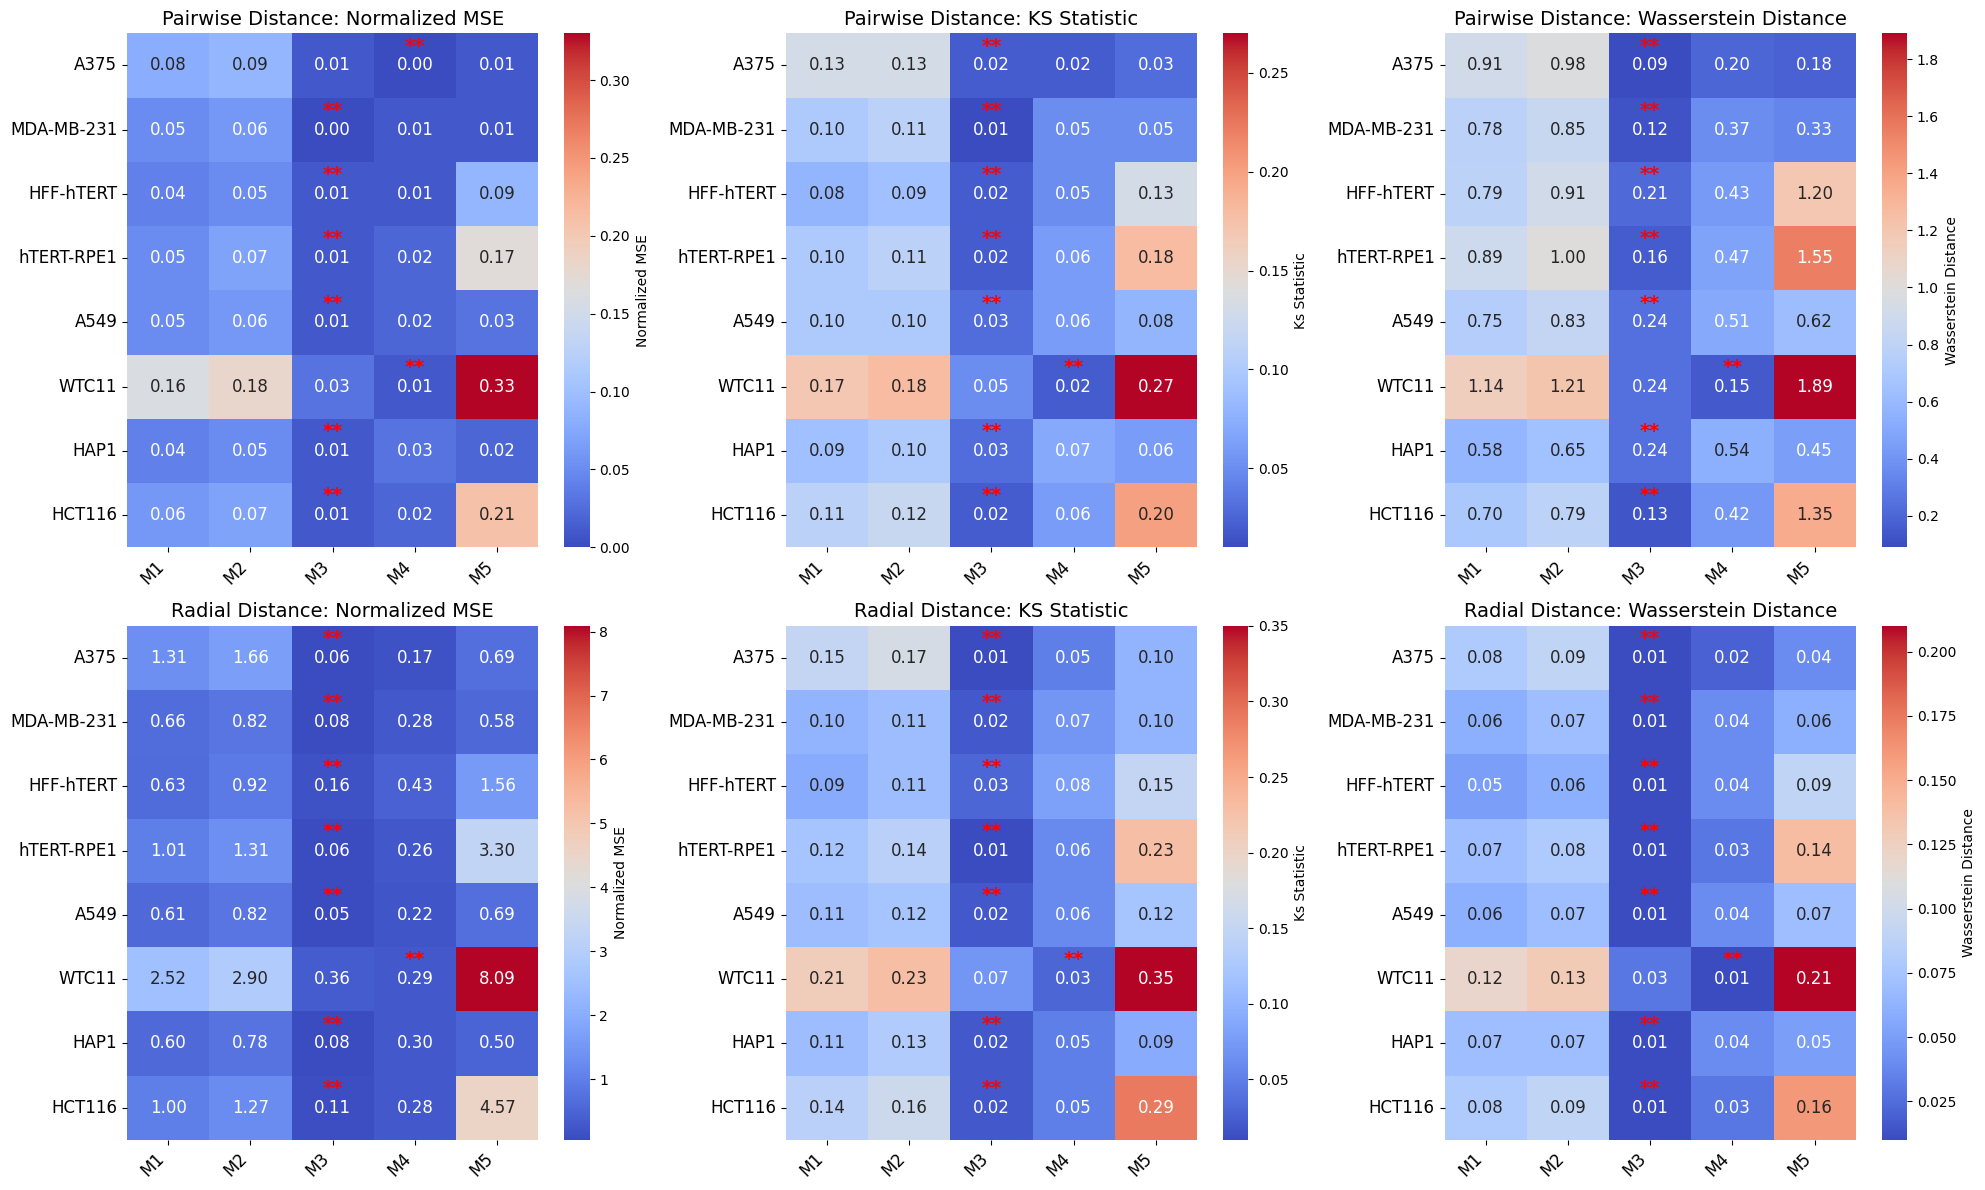

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Helper function to format labels
def format_label(text):
    if text in ['A375', 'MDA-MB-231', 'HFF-hTERT', 'hTERT-RPE1', 'A549', 'WTC11', 'HAP1', 'HCT116', 'KS statistic','Normalized MSE']:
        return text
    return ' '.join([word.capitalize() for word in text.replace('_', ' ').split()])

# Function to create heatmaps and mark the lowest values for each cell line
def plot_heatmap_with_min_highlight(ax, pivot_df, title, cbar_label, cmap='coolwarm'):
    # Ensure data is numeric and fill missing values
    pivot_df = pivot_df.apply(pd.to_numeric, errors='coerce').fillna(0)

    sns.heatmap(
        pivot_df, annot=True, cmap=cmap, cbar_kws={'label': format_label(cbar_label)}, 
        fmt=".2f", ax=ax, annot_kws={'size': 12}
    )
    
    # Highlight the minimum value in each row (for each cell line)
    for i in range(pivot_df.shape[0]):
        min_value_idx = pivot_df.iloc[i].idxmin()
        ax.text(
            pivot_df.columns.get_loc(min_value_idx) + 0.5, i + 0.2, '**', 
            color='red', ha='center', va='center', fontweight='bold', fontsize=14
        )

    # Format tick labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xticklabels([format_label(label) for label in pivot_df.columns], rotation=45, ha='right', fontsize=12)
    ax.set_yticklabels([format_label(label) for label in pivot_df.index], rotation=0, fontsize=12)

    # Set the title for each heatmap
    ax.set_title(title, fontsize=14)

# Extract subsets of the data for pairwise and radial distances
methods = ['M1', 'M2', 'M3', 'M4', 'M5']
pairwise_distances = results_df.xs('pairwise_distances', level='Metric')
radial_distances = results_df.xs('radial_distances', level='Metric')

# Create pivot tables for each metric type
pairwise_wass_pivot = pairwise_distances.xs('Wasserstein Distance', level='Metric Type', axis=1)
pairwise_mse_pivot = pairwise_distances.xs('Normalized MSE', level='Metric Type', axis=1)
pairwise_ks_pivot = pairwise_distances.xs('KS statistic', level='Metric Type', axis=1)

radial_wass_pivot = radial_distances.xs('Wasserstein Distance', level='Metric Type', axis=1)
radial_mse_pivot = radial_distances.xs('Normalized MSE', level='Metric Type', axis=1)
radial_ks_pivot = radial_distances.xs('KS statistic', level='Metric Type', axis=1)

# Convert pivot tables to numeric to avoid issues
pairwise_wass_pivot = pairwise_wass_pivot.apply(pd.to_numeric, errors='coerce').fillna(0)
pairwise_mse_pivot = pairwise_mse_pivot.apply(pd.to_numeric, errors='coerce').fillna(0)
pairwise_ks_pivot = pairwise_ks_pivot.apply(pd.to_numeric, errors='coerce').fillna(0)

radial_wass_pivot = radial_wass_pivot.apply(pd.to_numeric, errors='coerce').fillna(0)
radial_mse_pivot = radial_mse_pivot.apply(pd.to_numeric, errors='coerce').fillna(0)
radial_ks_pivot = radial_ks_pivot.apply(pd.to_numeric, errors='coerce').fillna(0)

# Create subplots for the heatmaps
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Pairwise Distance Heatmaps
plot_heatmap_with_min_highlight(axes[0, 0], pairwise_mse_pivot, 'Pairwise Distance: Normalized MSE', 'Normalized MSE')
plot_heatmap_with_min_highlight(axes[0, 1], pairwise_ks_pivot, 'Pairwise Distance: KS Statistic', 'KS Statistic')
plot_heatmap_with_min_highlight(axes[0, 2], pairwise_wass_pivot, 'Pairwise Distance: Wasserstein Distance', 'Wasserstein Distance')

# Radial Distance Heatmaps
plot_heatmap_with_min_highlight(axes[1, 0], radial_mse_pivot, 'Radial Distance: Normalized MSE', 'Normalized MSE')
plot_heatmap_with_min_highlight(axes[1, 1], radial_ks_pivot, 'Radial Distance: KS Statistic', 'KS Statistic')
plot_heatmap_with_min_highlight(axes[1, 2], radial_wass_pivot, 'Radial Distance: Wasserstein Distance', 'Wasserstein Distance')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [76]:
results_df

Method                                          M1                 \
Metric Type                   Wasserstein Distance Normalized MSE   
Cell Line  Metric                                                   
A375       pairwise_distances                 0.91           0.08   
           radial_distances                   0.08            1.3   
MDA-MB-231 pairwise_distances                 0.78           0.05   
           radial_distances                   0.06           0.64   
HFF-hTERT  pairwise_distances                 0.79           0.04   
           radial_distances                   0.05           0.62   
hTERT-RPE1 pairwise_distances                 0.89           0.05   
           radial_distances                   0.07           1.02   
A549       pairwise_distances                 0.75           0.05   
           radial_distances                   0.06           0.62   
WTC11      pairwise_distances                 1.14           0.16   
           radial_distances                   0.12           2.53   
HAP1       pairwise_distances                 0.58           0.04   
           radial_distances                   0.07            0.6   
HCT116     pairwise_distances                  0.7           0.06   
           radial_distances                   0.08           1.01   

Method                                                       M2  \
Metric Type                   KS statistic Wasserstein Distance   
Cell Line  Metric                                                 
A375       pairwise_distances         0.13                 0.98   
           radial_distances           0.15                 0.09   
MDA-MB-231 pairwise_distances          0.1                 0.85   
           radial_distances            0.1                 0.07   
HFF-hTERT  pairwise_distances         0.08                 0.91   
           radial_distances           0.09                 0.06   
hTERT-RPE1 pairwise_distances          0.1                  1.0   
           radial_distances           0.12                 0.08   
A549       pairwise_distances          0.1                 0.83   
           radial_distances           0.11                 0.07   
WTC11      pairwise_distances         0.17                 1.21   
           radial_distances           0.21                 0.13   
HAP1       pairwise_distances         0.09                 0.65   
           radial_distances           0.11                 0.08   
HCT116     pairwise_distances         0.11                 0.79   
           radial_distances           0.14                 0.09   

Method                                                     \
Metric Type                   Normalized MSE KS statistic   
Cell Line  Metric                                           
A375       pairwise_distances           0.09         0.13   
           radial_distances             1.65         0.17   
MDA-MB-231 pairwise_distances           0.06         0.11   
           radial_distances             0.81         0.11   
HFF-hTERT  pairwise_distances           0.05         0.09   
           radial_distances             0.91         0.11   
hTERT-RPE1 pairwise_distances           0.07         0.11   
           radial_distances             1.31         0.14   
A549       pairwise_distances           0.06          0.1   
           radial_distances             0.81         0.12   
WTC11      pairwise_distances           0.18         0.18   
           radial_distances             2.91         0.23   
HAP1       pairwise_distances           0.05          0.1   
           radial_distances             0.79         0.13   
HCT116     pairwise_distances           0.07         0.12   
           radial_distances             1.28         0.16   

Method                                          M3                 \
Metric Type                   Wasserstein Distance Normalized MSE   
Cell Line  Metric                                                   
A375       pairwise_distances                 0

In [25]:
from scipy.stats import ks_2samp, wasserstein_distance
# Function to calculate KL and Wasserstein for aggregated cell line data
def calculate_cell_line_metrics(cell_data, metric):
    wasserstein_results = {}
    
    # Concatenate real data for all cells in each cell line, ensuring no NaNs
    real_data = np.concatenate(cell_data.groupby('cell_type')[f'M0_{metric}'].apply(np.hstack).values)
    real_data = real_data[~np.isnan(real_data)]  # Remove NaN values
    
    for method in range(1, 6):
        # Concatenate synthetic data for all cells in each cell line, ensuring no NaNs
        synthetic_data = np.concatenate(cell_data.groupby('cell_type')[f'M{method}_{metric}'].apply(np.hstack).values)
        synthetic_data = synthetic_data[~np.isnan(synthetic_data)]  # Remove NaN values
        
        # Resample to match sizes
        if len(real_data) > len(synthetic_data):
            real_data_resampled = np.random.choice(real_data, size=len(synthetic_data), replace=False)
            synthetic_data_resampled = synthetic_data
        else:
            synthetic_data_resampled = np.random.choice(synthetic_data, size=len(real_data), replace=False)
            real_data_resampled = real_data
        
        if len(real_data_resampled) > 0 and len(synthetic_data_resampled) > 0:
           
            # Calculate Wasserstein Distance
            wasserstein_results[f'M{method}'] = wasserstein_distance(real_data_resampled, synthetic_data_resampled)
        else:
            wasserstein_results[f'M{method}'] = np.nan

    return wasserstein_results
# Example usage for radial distances at the cell line level
wasserstein_distances = calculate_cell_line_metrics(eight_cell_lines.loc[eight_cell_lines.spots_number<47], 'pairwise_distances')
print(wasserstein_distances)


{'M1': 0.812927168409023, 'M2': 0.8932860587016638, 'M3': 0.10822710451051616, 'M4': 0.3607370082031296, 'M5': 0.5463921773926479}


/tmp/ipykernel_29511/55146651.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=methods, y=values, palette="Blues_d")


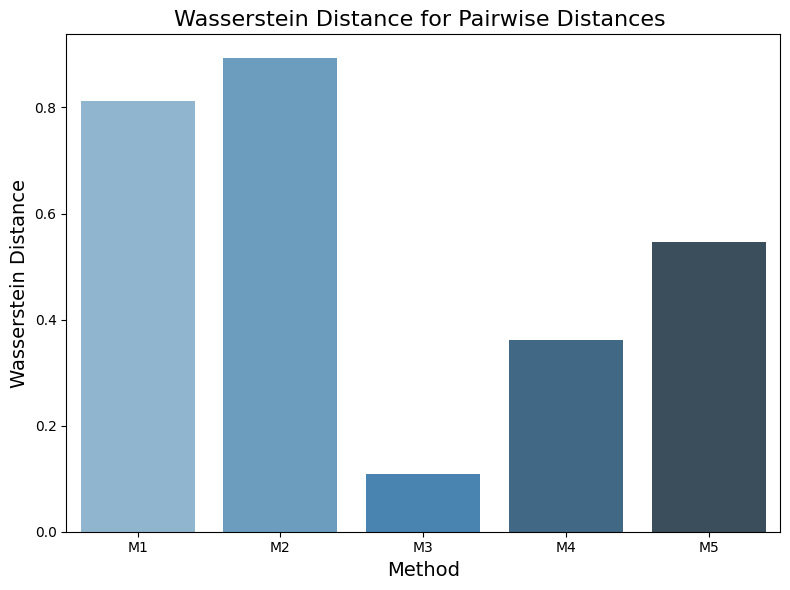

In [26]:

# Convert the dictionary to lists of methods and distances
methods = list(wasserstein_distances.keys())
values = list(wasserstein_distances.values())

# Create a barplot
plt.figure(figsize=(8, 6))
sns.barplot(x=methods, y=values, palette="Blues_d")

# Add titles and labels
plt.title('Wasserstein Distance for Pairwise Distances ', fontsize=16)
plt.xlabel('Method', fontsize=14)
plt.ylabel('Wasserstein Distance', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


{'M1': 0.07890176168797623, 'M2': 0.08824237744298795, 'M3': 0.006379088628375907, 'M4': 0.032166895897005915, 'M5': 0.04471506845801081}


/tmp/ipykernel_29511/3023867881.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=methods, y=values, palette="Blues_d")


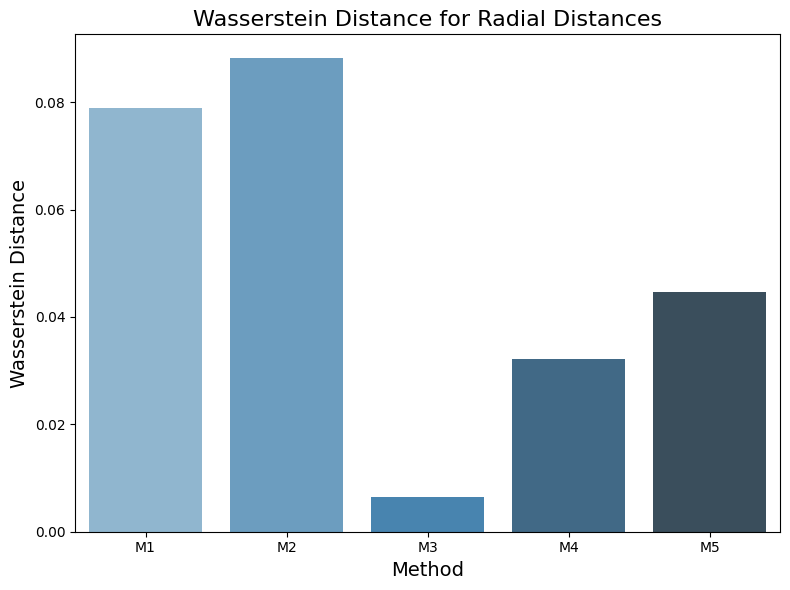

In [27]:
# Function to calculate KL and Wasserstein for aggregated cell line data
def calculate_cell_line_metrics(cell_data, metric):
    wasserstein_results = {}
    
    # Concatenate real data for all cells in each cell line, ensuring no NaNs
    real_data = np.concatenate(cell_data.groupby('cell_type')[f'M0_{metric}'].apply(np.hstack).values)
    real_data = real_data[~np.isnan(real_data)]  # Remove NaN values
    
    for method in range(1, 6):
        # Concatenate synthetic data for all cells in each cell line, ensuring no NaNs
        synthetic_data = np.concatenate(cell_data.groupby('cell_type')[f'M{method}_{metric}'].apply(np.hstack).values)
        synthetic_data = synthetic_data[~np.isnan(synthetic_data)]  # Remove NaN values
        
        # Resample to match sizes
        if len(real_data) > len(synthetic_data):
            real_data_resampled = np.random.choice(real_data, size=len(synthetic_data), replace=False)
            synthetic_data_resampled = synthetic_data
        else:
            synthetic_data_resampled = np.random.choice(synthetic_data, size=len(real_data), replace=False)
            real_data_resampled = real_data
        
        if len(real_data_resampled) > 0 and len(synthetic_data_resampled) > 0:
            
            # Calculate Wasserstein Distance
            wasserstein_results[f'M{method}'] = wasserstein_distance(real_data_resampled, synthetic_data_resampled)
        else:
            wasserstein_results[f'M{method}'] = np.nan

    return wasserstein_results
# Example usage for radial distances at the cell line level
wasserstein_distances = calculate_cell_line_metrics(eight_cell_lines.loc[eight_cell_lines.spots_number<47], 'radial_distances')
print(wasserstein_distances)

# Convert the dictionary to lists of methods and distances
methods = list(wasserstein_distances.keys())
values = list(wasserstein_distances.values())

# Create a barplot
plt.figure(figsize=(8, 6))
sns.barplot(x=methods, y=values, palette="Blues_d")

# Add titles and labels
plt.title('Wasserstein Distance for Radial Distances', fontsize=16)
plt.xlabel('Method', fontsize=14)
plt.ylabel('Wasserstein Distance', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


In [28]:
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import scipy.stats as stats

# Function to calculate Normalized MSE and Pearson Correlation for PDF comparison
def calculate_pdf_metrics(cell_data, metric):
    mse_results = {}
    pearson_results = {}
    
    # Concatenate real data for all cells in each cell line, ensuring no NaNs
    real_data = np.concatenate(cell_data.groupby('cell_type')[f'M0_{metric}'].apply(np.hstack).values)
    real_data = real_data[~np.isnan(real_data)]  # Remove NaN values
    
    for method in range(1, 6):
        # Concatenate synthetic data for all cells in each cell line, ensuring no NaNs
        synthetic_data = np.concatenate(cell_data.groupby('cell_type')[f'M{method}_{metric}'].apply(np.hstack).values)
        synthetic_data = synthetic_data[~np.isnan(synthetic_data)]  # Remove NaN values
        
        # Resample to match sizes
        if len(real_data) > len(synthetic_data):
            real_data_resampled = np.random.choice(real_data, size=len(synthetic_data), replace=False)
            synthetic_data_resampled = synthetic_data
        else:
            synthetic_data_resampled = np.random.choice(synthetic_data, size=len(real_data), replace=False)
            real_data_resampled = real_data
        
        if len(real_data_resampled) > 0 and len(synthetic_data_resampled) > 0:
            # Step 1: Calculate PDFs
            real_pdf, real_bins = np.histogram(real_data_resampled, bins=100, density=True)
            synthetic_pdf, _ = np.histogram(synthetic_data_resampled, bins=real_bins, density=True)
            
            # Step 2: Normalize the PDFs
            real_pdf = real_pdf / np.sum(real_pdf)
            synthetic_pdf = synthetic_pdf / np.sum(synthetic_pdf)
            
            # Step 3: Calculate Normalized Mean Squared Error (MSE)
            mse = mean_squared_error(real_pdf, synthetic_pdf)
            normalized_mse = mse / np.var(real_pdf)  # Normalize by variance of real PDF
            mse_results[f'M{method}'] = normalized_mse
            
            # Step 4: Calculate Pearson Correlation Coefficient
            pearson_corr, _ = pearsonr(real_pdf, synthetic_pdf)
            pearson_results[f'M{method}'] = pearson_corr
        else:
            mse_results[f'M{method}'] = np.nan
            pearson_results[f'M{method}'] = np.nan

    return mse_results, pearson_results

# Example usage for 'pairwise_distances' at the cell line level
mse_cell_line, pearson_cell_line = calculate_pdf_metrics(eight_cell_lines.loc[eight_cell_lines.spots_number<47], 'pairwise_distances')
print("Normalized MSE:", mse_cell_line)
print("Pearson Correlation Coefficient:", pearson_cell_line)


Normalized MSE: {'M1': 0.06314182465061736, 'M2': 0.07357922590966458, 'M3': 0.0052649252963136274, 'M4': 0.010975299087156689, 'M5': 0.03205625021088633}
Pearson Correlation Coefficient: {'M1': 0.9714586236087763, 'M2': 0.9665382049712947, 'M3': 0.9974741187920727, 'M4': 0.9958678212042781, 'M5': 0.988543143621143}


/tmp/ipykernel_29511/1987771402.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=methods, y=values, palette="Blues_d")


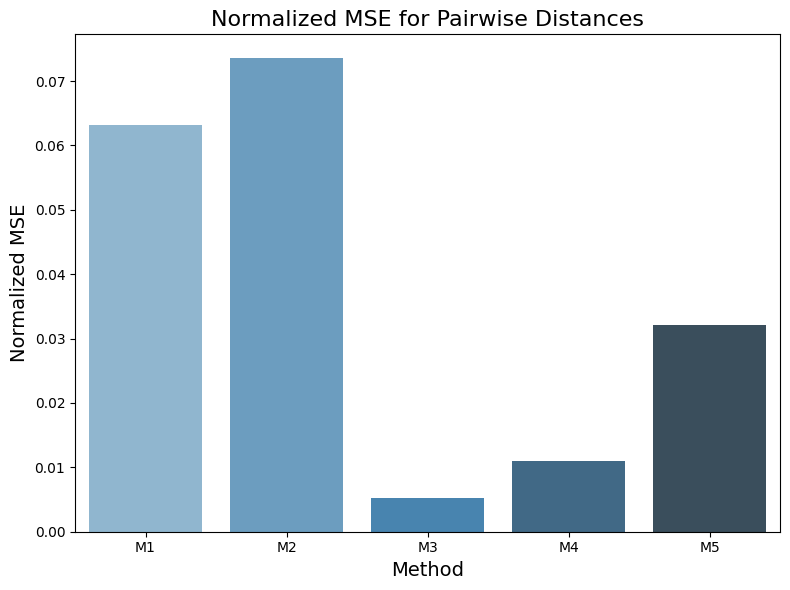

In [29]:

# Convert the dictionary to lists of methods and distances
methods = list(mse_cell_line.keys())
values = list(mse_cell_line.values())

# Create a barplot
plt.figure(figsize=(8, 6))
sns.barplot(x=methods, y=values, palette="Blues_d")

# Add titles and labels
plt.title('Normalized MSE for Pairwise Distances', fontsize=16)
plt.xlabel('Method', fontsize=14)
plt.ylabel('Normalized MSE', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


In [30]:
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import scipy.stats as stats

# Function to calculate Normalized MSE and Pearson Correlation for PDF comparison
def calculate_pdf_metrics(cell_data, metric):
    mse_results = {}
    pearson_results = {}
    
    # Concatenate real data for all cells in each cell line, ensuring no NaNs
    real_data = np.concatenate(cell_data.groupby('cell_type')[f'M0_{metric}'].apply(np.hstack).values)
    real_data = real_data[~np.isnan(real_data)]  # Remove NaN values
    
    for method in range(1, 6):
        # Concatenate synthetic data for all cells in each cell line, ensuring no NaNs
        synthetic_data = np.concatenate(cell_data.groupby('cell_type')[f'M{method}_{metric}'].apply(np.hstack).values)
        synthetic_data = synthetic_data[~np.isnan(synthetic_data)]  # Remove NaN values
        
        # Resample to match sizes
        if len(real_data) > len(synthetic_data):
            real_data_resampled = np.random.choice(real_data, size=len(synthetic_data), replace=False)
            synthetic_data_resampled = synthetic_data
        else:
            synthetic_data_resampled = np.random.choice(synthetic_data, size=len(real_data), replace=False)
            real_data_resampled = real_data
        
        if len(real_data_resampled) > 0 and len(synthetic_data_resampled) > 0:
            # Step 1: Calculate PDFs
            real_pdf, real_bins = np.histogram(real_data_resampled, bins=100, density=True)
            synthetic_pdf, _ = np.histogram(synthetic_data_resampled, bins=real_bins, density=True)
            
            # Step 2: Normalize the PDFs
            real_pdf = real_pdf / np.sum(real_pdf)
            synthetic_pdf = synthetic_pdf / np.sum(synthetic_pdf)
            
            # Step 3: Calculate Normalized Mean Squared Error (MSE)
            mse = mean_squared_error(real_pdf, synthetic_pdf)
            normalized_mse = mse / np.var(real_pdf)  # Normalize by variance of real PDF
            mse_results[f'M{method}'] = normalized_mse
            
            # Step 4: Calculate Pearson Correlation Coefficient
            pearson_corr, _ = pearsonr(real_pdf, synthetic_pdf)
            pearson_results[f'M{method}'] = pearson_corr
        else:
            mse_results[f'M{method}'] = np.nan
            pearson_results[f'M{method}'] = np.nan

    return mse_results, pearson_results

# Example usage for 'pairwise_distances' at the cell line level
mse_cell_line, pearson_cell_line = calculate_pdf_metrics(eight_cell_lines.loc[eight_cell_lines.spots_number<47], 'radial_distances')
print("Normalized MSE:", mse_cell_line)
print("Pearson Correlation Coefficient:", pearson_cell_line)


Normalized MSE: {'M1': 0.9861461602964768, 'M2': 1.3084704971196488, 'M3': 0.03965547941995409, 'M4': 0.20283204620915596, 'M5': 0.6974034646196502}
Pearson Correlation Coefficient: {'M1': 0.8025958193086538, 'M2': 0.7695903437502233, 'M3': 0.9809862305753526, 'M4': 0.900359048929242, 'M5': 0.7418602169294739}


/tmp/ipykernel_29511/52627895.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=methods, y=values, palette="Blues_d")


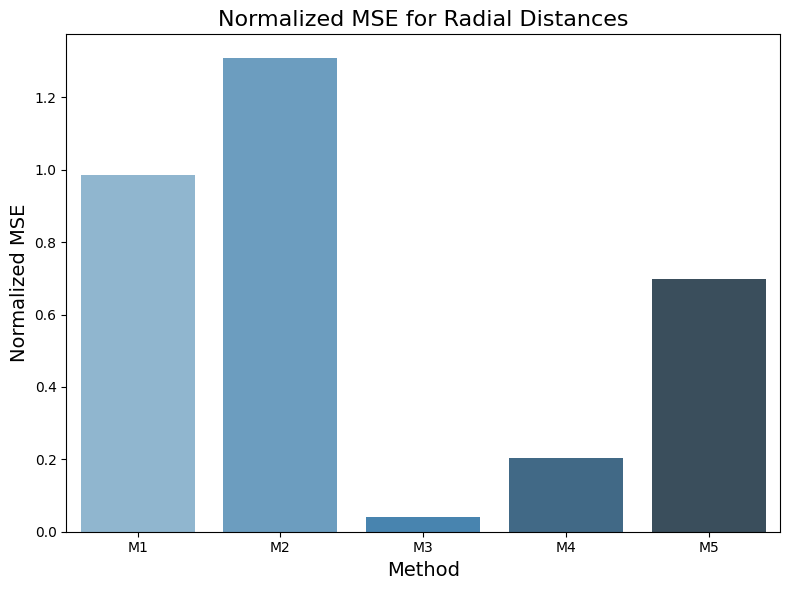

In [31]:

# Convert the dictionary to lists of methods and distances
methods = list(mse_cell_line.keys())
values = list(mse_cell_line.values())

# Create a barplot
plt.figure(figsize=(8, 6))
sns.barplot(x=methods, y=values, palette="Blues_d")

# Add titles and labels
plt.title('Normalized MSE for Radial Distances', fontsize=16)
plt.xlabel('Method', fontsize=14)
plt.ylabel('Normalized MSE', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


In [32]:
from scipy.stats import ks_2samp

# Function to calculate KS Test for distributions (KS statistic and p-value)
def calculate_ks_with_pvalue(cell_data, metric):
    ks_results = {}
    p_value_results = {}
    
    # Concatenate real data for all cells in each cell line
    real_data = np.concatenate(cell_data.groupby('cell_type')[f'M0_{metric}'].apply(np.hstack).values)
    real_data = real_data[~np.isnan(real_data)]  # Remove NaN values
    
    for method in range(1, 6):
        # Concatenate synthetic data for all cells in each cell line
        synthetic_data = np.concatenate(cell_data.groupby('cell_type')[f'M{method}_{metric}'].apply(np.hstack).values)
        synthetic_data = synthetic_data[~np.isnan(synthetic_data)]  # Remove NaN values
        
        # Resample to match sizes
        if len(real_data) > len(synthetic_data):
            real_data_resampled = np.random.choice(real_data, size=len(synthetic_data), replace=False)
            synthetic_data_resampled = synthetic_data
        else:
            synthetic_data_resampled = np.random.choice(synthetic_data, size=len(real_data), replace=False)
            real_data_resampled = real_data
        
        if len(real_data_resampled) > 0 and len(synthetic_data_resampled) > 0:
            # Perform KS test
            ks_stat, p_value = ks_2samp(real_data_resampled, synthetic_data_resampled)
            ks_results[f'M{method}'] = ks_stat
            p_value_results[f'M{method}'] = p_value
        else:
            ks_results[f'M{method}'] = np.nan
            p_value_results[f'M{method}'] = np.nan

    return ks_results, p_value_results

# Example usage
ks_results, p_value_results = calculate_ks_with_pvalue(eight_cell_lines.loc[eight_cell_lines.spots_number < 47], 'pairwise_distances')

print("KS Statistic:", ks_results)
# print("P-values:", p_value_results)


KS Statistic: {'M1': 0.11416050929358523, 'M2': 0.12347463332736774, 'M3': 0.01413843649596469, 'M4': 0.0470458244914308, 'M5': 0.07684001056767142}


/tmp/ipykernel_29511/4148972985.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=methods, y=values, palette="Blues_d")


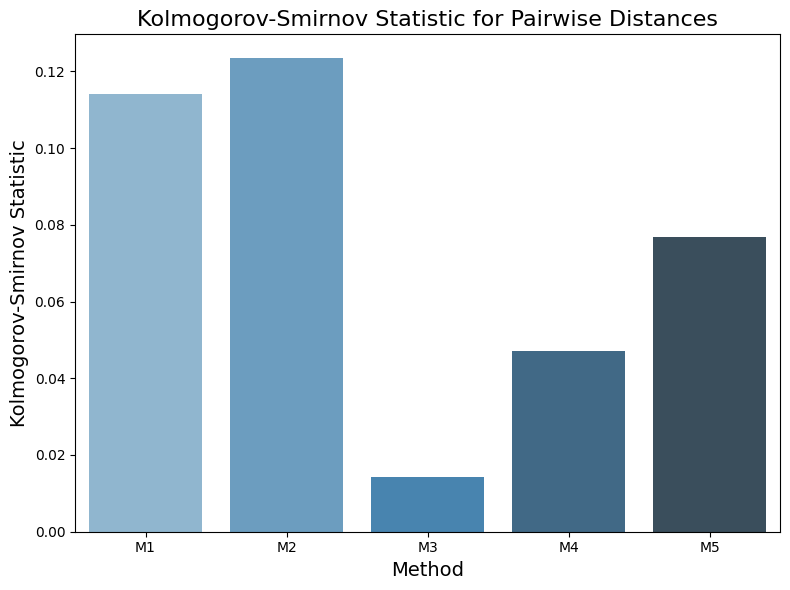

In [33]:
# Convert the dictionary to lists of methods and values
methods = list(ks_results.keys())
values = list(ks_results.values())

# Create a barplot
plt.figure(figsize=(8, 6))
sns.barplot(x=methods, y=values, palette="Blues_d")

# Add a red dashed horizontal line at p-value = 0.05
# plt.axhline(0.05, color='red', linestyle='--', linewidth=2, label='p = 0.05')

# Add titles and labels
plt.title('Kolmogorov-Smirnov Statistic for Pairwise Distances', fontsize=16)
plt.xlabel('Method', fontsize=14)
plt.ylabel('Kolmogorov-Smirnov Statistic', fontsize=14)

# Add legend for the red line
# plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [34]:
from scipy.stats import ks_2samp

# Function to calculate KS Test for distributions (KS statistic and p-value)
def calculate_ks_with_pvalue(cell_data, metric):
    ks_results = {}
    p_value_results = {}
    
    # Concatenate real data for all cells in each cell line
    real_data = np.concatenate(cell_data.groupby('cell_type')[f'M0_{metric}'].apply(np.hstack).values)
    real_data = real_data[~np.isnan(real_data)]  # Remove NaN values
    
    for method in range(1, 6):
        # Concatenate synthetic data for all cells in each cell line
        synthetic_data = np.concatenate(cell_data.groupby('cell_type')[f'M{method}_{metric}'].apply(np.hstack).values)
        synthetic_data = synthetic_data[~np.isnan(synthetic_data)]  # Remove NaN values
        
        # Resample to match sizes
        if len(real_data) > len(synthetic_data):
            real_data_resampled = np.random.choice(real_data, size=len(synthetic_data), replace=False)
            synthetic_data_resampled = synthetic_data
        else:
            synthetic_data_resampled = np.random.choice(synthetic_data, size=len(real_data), replace=False)
            real_data_resampled = real_data
        
        if len(real_data_resampled) > 0 and len(synthetic_data_resampled) > 0:
            # Perform KS test
            ks_stat, p_value = ks_2samp(real_data_resampled, synthetic_data_resampled)
            ks_results[f'M{method}'] = ks_stat
            p_value_results[f'M{method}'] = p_value
        else:
            ks_results[f'M{method}'] = np.nan
            p_value_results[f'M{method}'] = np.nan

    return ks_results, p_value_results

# Example usage
ks_results, p_value_results = calculate_ks_with_pvalue(eight_cell_lines.loc[eight_cell_lines.spots_number < 47], 'radial_distances')

print("KS Statistic:", ks_results)
# print("P-values:", p_value_results)


KS Statistic: {'M1': 0.13614273693610146, 'M2': 0.15172555330293902, 'M3': 0.01283994748804912, 'M4': 0.04614328225757658, 'M5': 0.09062652457616793}


/tmp/ipykernel_29511/510717751.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=methods, y=values, palette="Blues_d")


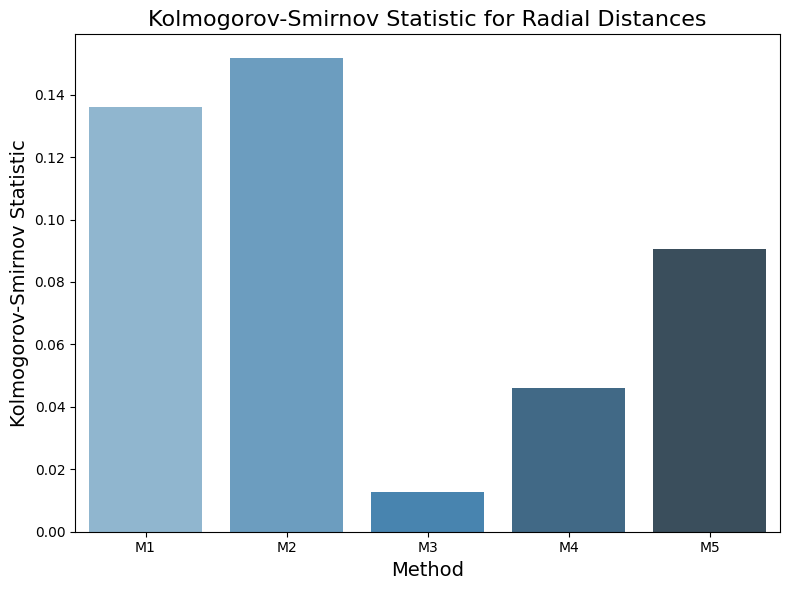

In [35]:
# Convert the dictionary to lists of methods and values
methods = list(ks_results.keys())
values = list(ks_results.values())

# Create a barplot
plt.figure(figsize=(8, 6))
sns.barplot(x=methods, y=values, palette="Blues_d")

# Add a red dashed horizontal line at p-value = 0.05
# plt.axhline(0.05, color='red', linestyle='--', linewidth=2, label='p = 0.05')

# Add titles and labels
plt.title('Kolmogorov-Smirnov Statistic for Radial Distances', fontsize=16)
plt.xlabel('Method', fontsize=14)
plt.ylabel('Kolmogorov-Smirnov Statistic', fontsize=14)

# Add legend for the red line
# plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:


import pandas as pd

def save_metrics_as_tables(wasserstein_results, mse_results, ks_results, p_value_results, filename="/data/krishnendu/ripley_paper/scr_ncaph2_results/spot_medeling_metrics_summary.xlsx"):
    # Prepare data for tables
    scrambled_data = {}
    ncaph2_data = {}

    for method in ["M1", "M2", "M3", "M4", "M5"]:
        # Scrambled metrics
        scrambled_data[method] = {
            "wasserstein_distance": round(wasserstein_results['scrambled'].get(method, float('nan')), 2),
            "normalized_mse": round(mse_results['scrambled'].get(method, float('nan')), 2),
            "ks_statistic": round(ks_results['scrambled'].get(method, float('nan')), 2),
        }

        # NCAPH2 metrics
        ncaph2_data[method] = {
            "wasserstein_distance": round(wasserstein_results['NCAPH2'].get(method, float('nan')), 2),
            "normalized_mse": round(mse_results['NCAPH2'].get(method, float('nan')), 2),
            "ks_statistic": round(ks_results['NCAPH2'].get(method, float('nan')), 2),
        }

    # Convert to DataFrames
    scrambled_df = pd.DataFrame(scrambled_data).T  # Transpose to make methods columns
    ncaph2_df = pd.DataFrame(ncaph2_data).T        # Transpose to make methods columns

    # Save to an Excel file with separate sheets for each table
    with pd.ExcelWriter(filename) as writer:
        scrambled_df.to_excel(writer, sheet_name="Scrambled")
        ncaph2_df.to_excel(writer, sheet_name="NCAPH2")

    print(f"Metrics tables saved to {filename}")

# Example usage
wasserstein_results = calculate_wasserstein_for_each_gene_symbol(eight_cell_lines.loc[eight_cell_lines.spots_number < 47], 'radial_distances')
mse_results = calculate_normalized_mse_for_each_gene_symbol(eight_cell_lines.loc[eight_cell_lines.spots_number < 47], 'radial_distances')
ks_results, p_value_results = calculate_ks_for_each_gene_symbol(eight_cell_lines.loc[eight_cell_lines.spots_number < 47], 'radial_distances')

# Save the results as tables
save_metrics_as_tables(wasserstein_results, mse_results, ks_results, p_value_results)


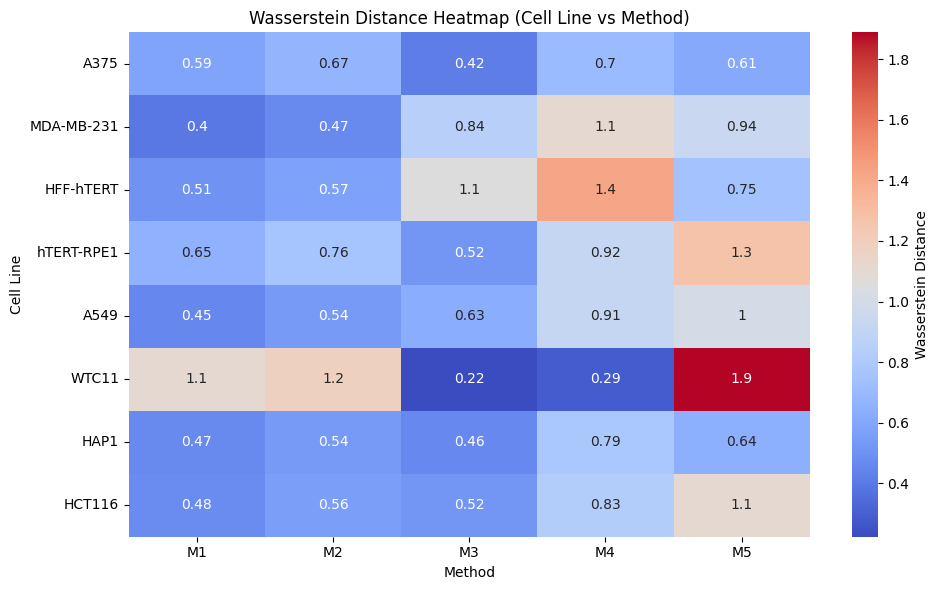

In [36]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

# Function to calculate Wasserstein Distance for each cell line separately
def calculate_wasserstein_cell_line(cell_data, metric):
    wasserstein_results = {}
    
    # Iterate over each unique cell line
    cell_lines = cell_data['cell_type'].unique()
    
    for cell_line in cell_lines:
        wasserstein_results[cell_line] = {}
        
        # Get the real data for the current cell line, ensuring no NaNs
        real_data = np.concatenate(cell_data[cell_data['cell_type'] == cell_line][f'M0_{metric}'].apply(np.hstack).values)
        real_data = real_data[~np.isnan(real_data)]  # Remove NaN values
        
        for method in range(1, 6):
            # Get the synthetic data for the current cell line and method
            synthetic_data = np.concatenate(cell_data[cell_data['cell_type'] == cell_line][f'M{method}_{metric}'].apply(np.hstack).values)
            synthetic_data = synthetic_data[~np.isnan(synthetic_data)]  # Remove NaN values
            
            # Resample to match sizes
            if len(real_data) > len(synthetic_data):
                real_data_resampled = np.random.choice(real_data, size=len(synthetic_data), replace=False)
                synthetic_data_resampled = synthetic_data
            else:
                synthetic_data_resampled = np.random.choice(synthetic_data, size=len(real_data), replace=False)
                real_data_resampled = real_data
            
            if len(real_data_resampled) > 0 and len(synthetic_data_resampled) > 0:
                # Calculate Wasserstein Distance
                wasserstein_results[cell_line][f'M{method}'] = wasserstein_distance(real_data_resampled, synthetic_data_resampled)
            else:
                wasserstein_results[cell_line][f'M{method}'] = np.nan

    return wasserstein_results

# Example usage for calculating Wasserstein distances at the cell line level
wasserstein_cell_line = calculate_wasserstein_cell_line(eight_cell_lines, 'pairwise_distances')

# Create a heatmap from the Wasserstein distance results
def plot_wasserstein_heatmap(wasserstein_results):
    # Convert the dictionary to a DataFrame for plotting
    import pandas as pd
    wasserstein_df = pd.DataFrame(wasserstein_results).T  # Transpose to match cell lines vs methods
    
    # Create the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(wasserstein_df, annot=True, cmap="coolwarm", cbar_kws={'label': 'Wasserstein Distance'})
    plt.title("Wasserstein Distance Heatmap (Cell Line vs Method)")
    plt.xlabel("Method")
    plt.ylabel("Cell Line")
    plt.tight_layout()
    plt.show()

# Plot the heatmap
plot_wasserstein_heatmap(wasserstein_cell_line)


In [42]:
# Function to calculate KL and Wasserstein for aggregated cell line data
def calculate_cell_line_metrics(cell_data, metric):
    wasserstein_results = {}
    
    # Concatenate real data for all cells in each cell line, ensuring no NaNs
    real_data = np.concatenate(cell_data.groupby('cell_type')[f'M0_{metric}'].apply(np.hstack).values)
    real_data = real_data[~np.isnan(real_data)]  # Remove NaN values
    
    for method in range(1, 6):
        # Concatenate synthetic data for all cells in each cell line, ensuring no NaNs
        synthetic_data = np.concatenate(cell_data.groupby('cell_type')[f'M{method}_{metric}'].apply(np.hstack).values)
        synthetic_data = synthetic_data[~np.isnan(synthetic_data)]  # Remove NaN values
        
        # Resample to match sizes
        if len(real_data) > len(synthetic_data):
            real_data_resampled = np.random.choice(real_data, size=len(synthetic_data), replace=False)
            synthetic_data_resampled = synthetic_data
        else:
            synthetic_data_resampled = np.random.choice(synthetic_data, size=len(real_data), replace=False)
            real_data_resampled = real_data
        
        if len(real_data_resampled) > 0 and len(synthetic_data_resampled) > 0:
            
            # Calculate Wasserstein Distance
            wasserstein_results[f'M{method}'] = wasserstein_distance(real_data_resampled, synthetic_data_resampled)
        else:
            wasserstein_results[f'M{method}'] = np.nan

    return wasserstein_results
# Example usage for radial distances at the cell line level
wasserstein_cell_line = calculate_cell_line_metrics(eight_cell_lines.loc[eight_cell_lines.spots_number<47], 'radial_distances')
# print(kl_cell_line)
print(wasserstein_cell_line)


{'M1': 0.07879598654465145, 'M2': 0.08817719006921011, 'M3': 0.08836509157928005, 'M4': 0.08980002227657895, 'M5': 0.0063403255890810695, 'M6': 0.03219592619459877, 'M7': 0.05226783286789766}


In [16]:
from scipy.stats import ks_2samp, wasserstein_distance
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

metrics_to_analyze = ['ripley_k_score', 'assortativity', 'modularity', 'morans_i', 'mean_nearest_neighbor_distance', 'dispersion_index']
methods = ['M1', 'M2', 'M3', 'M4', 'M5']

# Function to calculate Normalized MSE, KS Statistic, and Wasserstein Distance
def calculate_metrics(data1, data2):
    # Normalize the data for MSE
    data1_norm = (data1 - np.min(data1)) / (np.max(data1) - np.min(data1) + 1e-10)
    data2_norm = (data2 - np.min(data2)) / (np.max(data2) - np.min(data2) + 1e-10)
    
    # Calculate Normalized Mean Squared Error (MSE)
    mse = mean_squared_error(data1_norm, data2_norm)
    normalized_mse = mse / np.var(data1_norm)  # Normalize by variance of real data
    
    # Calculate KS Statistic
    ks_stat, _ = ks_2samp(data1, data2)
    
    # Calculate Wasserstein Distance
    w_distance = wasserstein_distance(data1, data2)
    
    return normalized_mse, ks_stat, w_distance

# Prepare the results dictionary
distance_results = []

for metric in metrics_to_analyze:
    for method in methods:
        for cell_line in eight_cell_lines.cell_type.unique():
            real_data = eight_cell_lines.loc[(eight_cell_lines.spots_number < 47)&(eight_cell_lines.cell_type==cell_line)][f'M0_{metric}'].dropna()
            method_data = eight_cell_lines.loc[(eight_cell_lines.spots_number < 47)&(eight_cell_lines.cell_type==cell_line)][f'{method}_{metric}'].dropna()
            
            # Align real and method data to ensure equal sample size
            real_data, method_data = real_data.align(method_data, join='inner')
            
            # Calculate Normalized MSE, KS Statistic, and Wasserstein Distance
            normalized_mse, ks_stat, w_distance = calculate_metrics(real_data.values, method_data.values)
            distance_results.append({
                'Cell Line': cell_line,
                'Metric': metric,
                'Method': method,
                'Normalized MSE': normalized_mse,
                'KS Statistic': ks_stat,
                'Wasserstein Distance': w_distance
            })

# Display results
distance_results_df = pd.DataFrame(distance_results)
from IPython.display import display
display(distance_results_df)


,Cell Line,Metric,Method,Normalized MSE,KS Statistic,Wasserstein Distance
0,A375,ripley_k_score,M1,1.582484,0.384210,15.851884
1,MDA-MB-231,ripley_k_score,M1,1.364332,0.288454,10.374515
2,HFF-hTERT,ripley_k_score,M1,1.492576,0.236364,6.861077
3,hTERT-RPE1,ripley_k_score,M1,1.534757,0.268657,8.518517
4,A549,ripley_k_score,M1,1.363393,0.221851,8.142249
...,...,...,...,...,...,...
235,hTERT-RPE1,dispersion_index,M5,3.534907,0.376628,0.418089
236,A549,dispersion_index,M5,0.994994,0.097196,0.067300
237,WTC11,dispersion_index,M5,0.624780,0.453674,0.373046
238,HAP1,dispersion_index,M5,2.115890,0.111645,0.069452


In [108]:
from scipy.stats import ks_2samp, wasserstein_distance
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

metrics_to_analyze = ['ripley_k_score', 'assortativity', 'modularity', 'morans_i', 'mean_nearest_neighbor_distance', 'dispersion_index']
methods = ['M1', 'M2', 'M3', 'M4', 'M5']

# Function to compute the empirical CDF
def compute_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

# Function to calculate Normalized MSE (based on CDF), KS Statistic, and Wasserstein Distance
def calculate_metrics(data1, data2):
    # Compute the CDFs for both datasets
    x1, cdf1 = compute_cdf(data1)
    x2, cdf2 = compute_cdf(data2)
    
    # Interpolate both CDFs to align them on a common set of points
    min_x = min(np.min(x1), np.min(x2))
    max_x = max(np.max(x1), np.max(x2))
    common_points = np.linspace(min_x, max_x, 100)  # 100 common points for interpolation
    
    interp_cdf1 = interp1d(x1, cdf1, bounds_error=False, fill_value=(0, 1))(common_points)
    interp_cdf2 = interp1d(x2, cdf2, bounds_error=False, fill_value=(0, 1))(common_points)
    
    # Calculate Mean Squared Error (MSE) between the CDFs
    mse_cdf = mean_squared_error(interp_cdf1, interp_cdf2)
    normalized_mse_cdf = mse_cdf / np.var(interp_cdf1)  # Normalize by the variance of the real CDF
    
    # Calculate KS Statistic
    ks_stat, _ = ks_2samp(data1, data2)
    
    # Calculate Wasserstein Distance
    w_distance = wasserstein_distance(data1, data2)
    
    return normalized_mse_cdf, ks_stat, w_distance

# Prepare the results dictionary
distance_results = []

for metric in metrics_to_analyze:
    for method in methods:
        for cell_line in eight_cell_lines.cell_type.unique():
            real_data = eight_cell_lines.loc[(eight_cell_lines.spots_number < 47)&(eight_cell_lines.cell_type==cell_line)][f'M0_{metric}'].dropna()
            method_data = eight_cell_lines.loc[(eight_cell_lines.spots_number < 47)&(eight_cell_lines.cell_type==cell_line)][f'{method}_{metric}'].dropna()
        
            # Align real and method data to ensure equal sample size
            real_data, method_data = real_data.align(method_data, join='inner')
            
            # Calculate Normalized MSE (CDF), KS Statistic, and Wasserstein Distance
            normalized_mse_cdf, ks_stat, w_distance = calculate_metrics(real_data.values, method_data.values)
            distance_results.append({
                'Cell Line': cell_line,
                'Metric': metric,
                'Method': method,
                'Normalized MSE': normalized_mse_cdf,
                'KS Statistic': ks_stat,
                'Wasserstein Distance': w_distance
            })

# Display results
distance_results_df = pd.DataFrame(distance_results)
distance_results_df.loc[distance_results_df['Metric']=='mean_nearest_neighbor_distance', 'Metric']="MNND"

from IPython.display import display
display(distance_results_df)


,Cell Line,Metric,Method,Normalized MSE,KS Statistic,Wasserstein Distance
0,A375,ripley_k_score,M1,0.904558,0.384210,15.851884
1,MDA-MB-231,ripley_k_score,M1,0.566356,0.288454,10.374515
2,HFF-hTERT,ripley_k_score,M1,0.279467,0.236364,6.861077
3,hTERT-RPE1,ripley_k_score,M1,0.382216,0.268657,8.518517
4,A549,ripley_k_score,M1,0.381251,0.221851,8.142249
...,...,...,...,...,...,...
235,hTERT-RPE1,dispersion_index,M5,0.133852,0.376628,0.418089
236,A549,dispersion_index,M5,0.007528,0.097196,0.067300
237,WTC11,dispersion_index,M5,0.230624,0.453674,0.373046
238,HAP1,dispersion_index,M5,0.010707,0.111645,0.069452


In [15]:
distance_results_df

NameError: name 'distance_results_df' is not defined

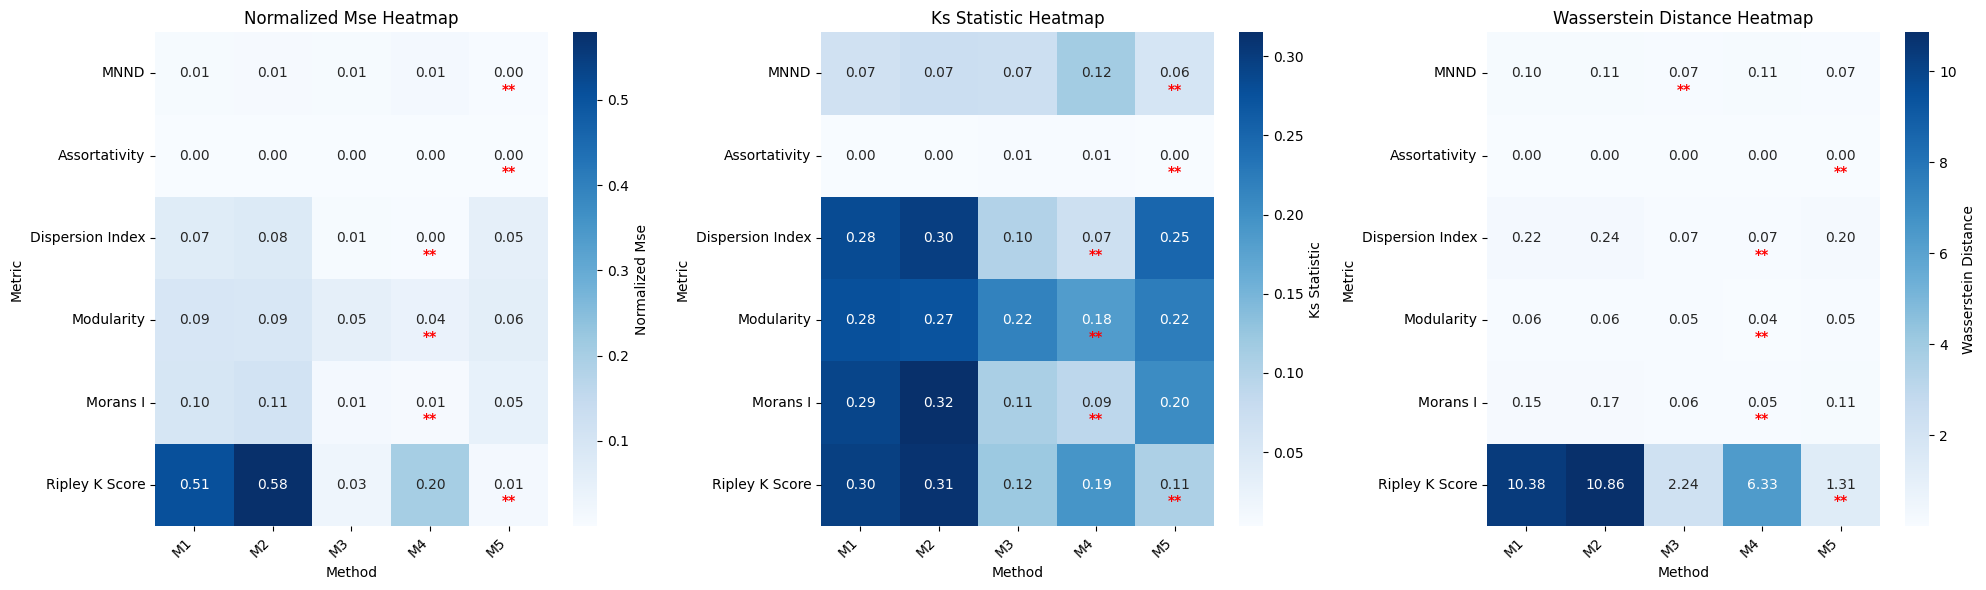

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Helper function to format labels
def format_label(text):
    if (text=='MNND') or (text=="MSE") or (text=="KS"):
        return text
    return ' '.join([word.capitalize() for word in text.replace('_', ' ').split()])

# Function to create heatmaps and mark the lowest values for each metric
def plot_heatmap_with_min_highlight(ax, pivot_df, title, cbar_label):
    sns.heatmap(
        pivot_df, annot=True, cmap='Blues', cbar_kws={'label': format_label(cbar_label)}, 
        fmt=".2f", ax=ax, annot_kws={'size': 10}
    )
    
    # Highlight the minimum value in each row (for each metric)
    for i in range(pivot_df.shape[0]):
        min_value_idx = pivot_df.iloc[i].idxmin()
        min_value = pivot_df.iloc[i].min()
        ax.text(pivot_df.columns.get_loc(min_value_idx) + 0.5, i + 0.7, '**', 
                color='red', ha='center', va='center', fontweight='bold', fontsize=10)

    # Format tick labels
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xticklabels([format_label(label) for label in pivot_df.columns], rotation=45, ha='right')
    ax.set_yticklabels([format_label(label) for label in pivot_df.index], rotation=0)

    # Set the title for each heatmap
    ax.set_title(title)

# Pivot the dataframe for heatmap plotting
mse_pivot = distance_results_df.pivot(index='Metric', columns='Method', values='Normalized MSE')
ks_pivot = distance_results_df.pivot(index='Metric', columns='Method', values='KS Statistic')
wass_pivot = distance_results_df.pivot(index='Metric', columns='Method', values='Wasserstein Distance')

# Create a 1x3 subplot layout
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot heatmap for Normalized MSE
plot_heatmap_with_min_highlight(axes[0], mse_pivot, 'Normalized MSE Heatmap', 'Normalized MSE')

# Plot heatmap for KS Statistic
plot_heatmap_with_min_highlight(axes[1], ks_pivot, 'KS Statistic Heatmap', 'KS Statistic')

# Plot heatmap for Wasserstein Distance
plot_heatmap_with_min_highlight(axes[2], wass_pivot, 'Wasserstein Distance Heatmap', 'Wasserstein Distance')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [110]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Path to save the plots
output_dir = "/data/krishnendu/ripley_paper/8cell_lines/metrics_plots"
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Helper function to format labels
def format_label(text):
    if text in ['MNND', 'MSE', 'KS']:
        return text
    return ' '.join([word.capitalize() for word in text.replace('_', ' ').split()])

# Function to plot and save heatmap for a single cell line
def plot_and_save_heatmap_for_cell_line(cell_line, data, output_dir):
    # Filter data for the current cell line
    cell_data = data[data['Cell Line'] == cell_line]

    # Pivot the data for each metric
    mse_pivot = cell_data.pivot(index='Metric', columns='Method', values='Normalized MSE')
    ks_pivot = cell_data.pivot(index='Metric', columns='Method', values='KS Statistic')
    wass_pivot = cell_data.pivot(index='Metric', columns='Method', values='Wasserstein Distance')

    # Create a 1x3 subplot layout for this cell line
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    heatmaps = {'Normalized MSE': mse_pivot, 'KS Statistic': ks_pivot, 'Wasserstein Distance': wass_pivot}

    for ax, (title, pivot_df) in zip(axes, heatmaps.items()):
        sns.heatmap(
            pivot_df, annot=True, cmap='Blues', cbar_kws={'label': format_label(title)},
            fmt=".2f", ax=ax, annot_kws={'size': 10}
        )
        
        # Highlight the minimum value in each row
        for i in range(pivot_df.shape[0]):
            min_value_idx = pivot_df.iloc[i].idxmin()
            min_value = pivot_df.iloc[i].min()
            ax.text(
                pivot_df.columns.get_loc(min_value_idx) + 0.5, i + 0.5, '**', 
                color='red', ha='center', va='center', fontweight='bold', fontsize=10
            )

        # Format tick labels
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.set_xticklabels([format_label(label) for label in pivot_df.columns], rotation=45, ha='right')
        ax.set_yticklabels([format_label(label) for label in pivot_df.index], rotation=0)
        
        # Set the title for each heatmap
        ax.set_title(f'{cell_line} - {title}', fontsize=14)

    # Adjust layout
    plt.tight_layout()

    # Save the figure to the specified directory
    output_path = os.path.join(output_dir, f"{cell_line.replace(' ', '_')}_metrics_heatmap.png")
    plt.savefig(output_path, dpi=300)
    plt.close(fig)  # Close the figure to free up memory

# Iterate over each unique cell line and create and save heatmaps
for cell_line in distance_results_df['Cell Line'].unique():
    plot_and_save_heatmap_for_cell_line(cell_line, distance_results_df, output_dir)


In [91]:
from scipy.spatial.distance import mahalanobis
from scipy.stats import chisquare
import numpy as np
import numpy as np

# Function to calculate Mahalanobis Distance with regularization
def calculate_mahalanobis_distance(real_data, method_data, regularization=1e-5):
    # Combine both real and method data for covariance calculation
    data = np.vstack([real_data, method_data])
    
    # Covariance matrix
    cov_matrix = np.cov(data.T)
    
    # Add regularization to the diagonal to make the matrix invertible
    cov_matrix += np.eye(cov_matrix.shape[0]) * regularization
    
    # Inverse of the covariance matrix
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    
    # Calculate Mahalanobis distance for each point
    distances = []
    for r, m in zip(real_data, method_data):
        dist = mahalanobis(r, m, inv_cov_matrix)
        distances.append(dist)
    
    # Return the average Mahalanobis distance across all points
    return np.mean(distances)
# Function to calculate Chi-Squared Distance remains the same

# Function to calculate Chi-Squared Distance
def calculate_chi_squared_distance(real_data, method_data):
    real_hist, _ = np.histogram(real_data, bins='auto')
    method_hist, _ = np.histogram(method_data, bins='auto')
    # Normalize histograms
    real_hist = real_hist / np.sum(real_hist)
    method_hist = method_hist / np.sum(method_hist)
    return chisquare(f_obs=method_hist, f_exp=real_hist)[0]

# Add Mahalanobis and Chi-squared distances to results
additional_distances_results = []

for metric in metrics_to_analyze:
    for method in methods:
        real_data = eight_cell_lines[f'M0_{metric}'].dropna()
        method_data = eight_cell_lines[f'{method}_{metric}'].dropna()
        
        # Align real and method data to ensure equal sample size
        real_data, method_data = real_data.align(method_data, join='inner')
        
        # Calculate Mahalanobis and Chi-squared distances
        mahalanobis_dist = calculate_mahalanobis_distance(real_data.values, method_data.values)
        chi_squared_dist = calculate_chi_squared_distance(real_data.values, method_data.values)
        
        additional_distances_results.append({
            'Metric': metric,
            'Method': method,
            'Mahalanobis Distance': mahalanobis_dist,
            'Chi-Squared Distance': chi_squared_dist
        })

# Convert to dataframe
additional_distances_df = pd.DataFrame(additional_distances_results)

# Combine with the previous distance results
distance_results_combined = pd.merge(distance_results_df, additional_distances_df, on=['Metric', 'Method'])

# Display the combined results
distance_results_combined.head()



KeyboardInterrupt



In [ ]:
# Function to create heatmaps with minimum value highlighted for each distance metric
def plot_combined_heatmap_with_min_highlight(pivot_df, title, cbar_label):
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(pivot_df, annot=True, cmap='Blues', cbar_kws={'label': cbar_label}, fmt=".4f")
    
    # Highlight the minimum value in each row (for each metric)
    for i in range(pivot_df.shape[0]):
        min_value_idx = pivot_df.iloc[i].idxmin()
        min_value = pivot_df.iloc[i].min()
        ax.text(pivot_df.columns.get_loc(min_value_idx) + 0.5, i + 0.5, f'← {min_value_idx}', color='red', 
                ha='center', va='center', fontweight='bold')

    plt.title(title)
    plt.tight_layout()
    plt.show()

# Pivot the dataframe for heatmap plotting
mahalanobis_pivot = distance_results_combined.pivot(index='Metric', columns='Method', values='Mahalanobis Distance')
chi_squared_pivot = distance_results_combined.pivot(index='Metric', columns='Method', values='Chi-Squared Distance')

# Plot heatmap for Mahalanobis Distance
plot_combined_heatmap_with_min_highlight(mahalanobis_pivot, 'Mahalanobis Distance Heatmap', 'Mahalanobis Distance')

# Plot heatmap for Chi-Squared Distance
plot_combined_heatmap_with_min_highlight(chi_squared_pivot, 'Chi-Squared Distance Heatmap', 'Chi-Squared Distance')


In [7]:
simulation_results = pd.read_pickle('/data/krishnendu/ripley_paper/8cell_lines/simulation_results.pkl')

In [8]:
simulation_results

,coordinates,radii,pairwise_distances
0,"[[-12.092274144615144, -83.5985372412739], [6....","[15.53143470574876, 14.407544380336637, 12.473...","[169.96549819177406, 25.540359347127236, 9.124..."
1,"[[-12.092274144615144, -83.5985372412739], [6....","[15.53143470574876, 14.407544380336637, 12.473...","[169.96549819177406, 25.540359347127236, 9.124..."
2,"[[-12.092274144615144, -83.5985372412739], [6....","[15.53143470574876, 14.407544380336637, 12.473...","[169.96549819177406, 25.540359347127236, 9.124..."
3,"[[-12.092274144615144, -83.5985372412739], [6....","[15.53143470574876, 14.407544380336637, 12.473...","[169.96549819177406, 25.540359347127236, 9.124..."
4,"[[-12.092274144615144, -83.5985372412739], [6....","[15.53143470574876, 14.407544380336637, 12.473...","[169.96549819177406, 25.540359347127236, 9.124..."
...,...,...,...
99995,"[[-16.865602124356762, 83.97413453188777], [9....","[14.34894159791897, 15.274359555467385, 11.613...","[26.582457411694826, 6.929933540097618, 176.21..."
99996,"[[10.88705014016022, 85.48488374541415], [-13....","[13.824636875024769, 11.985197351663945, 11.35...","[24.145701768792414, 3.117119845525712, 180.27..."
99997,"[[5.158810111737527, 92.47391603097861], [-3.4...","[7.3822993814171225, 12.170158899513456, 11.19...","[180.44109657329594, 9.901487861089334, 181.79..."
99998,"[[10.88705014016022, 85.48488374541415], [-13....","[13.824636875024769, 11.985197351663945, 11.35...","[24.145701768792414, 3.117119845525712, 180.27..."


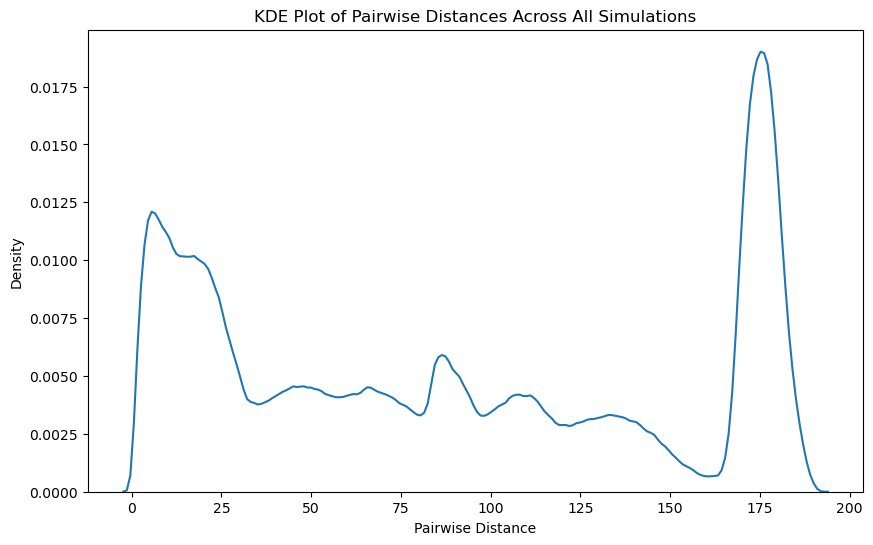

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have loaded the DataFrame `simulation_results`
# Flatten all pairwise distances into one array
all_pairwise_distances = np.concatenate(simulation_results['pairwise_distances'].values)

# Plot the KDE of pairwise distances
plt.figure(figsize=(10, 6))
sns.kdeplot(all_pairwise_distances, bw_adjust=0.5)  # bw_adjust can control smoothness
plt.title('KDE Plot of Pairwise Distances Across All Simulations')
plt.xlabel('Pairwise Distance')
plt.ylabel('Density')
plt.show()


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Assuming simulation_results is already loaded
output_directory = '/data2/circle_simulation_images'

# Create the output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Function to plot the chromosomes within the nucleus for each row
def plot_chromosomes_in_nucleus(row_index, coordinates, radii, nucleus_radius=100):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_aspect('equal')
    
    # Set limits for the nucleus
    ax.set_xlim(-nucleus_radius, nucleus_radius)
    ax.set_ylim(-nucleus_radius, nucleus_radius)
    
    # Draw the nucleus
    nucleus = Circle((0, 0), nucleus_radius, fill=False, edgecolor='black', linewidth=2)
    ax.add_patch(nucleus)
    
    # Draw each chromosome as a circle
    for (x, y), radius in zip(coordinates, radii):
        chromosome_circle = Circle((x, y), radius, edgecolor='blue', fill=False)
        ax.add_patch(chromosome_circle)
    
    # Remove axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Save the figure
    output_path = os.path.join(output_directory, f'circle_simulation_{row_index}.jpg')
    plt.savefig(output_path, format='jpg', dpi=300)
    plt.close()

# Iterate over each row in the DataFrame and plot the chromosomes
for idx, row in simulation_results.iterrows():
    plot_chromosomes_in_nucleus(idx, row['coordinates'], row['radii'])

print(f"All images have been saved to {output_directory}.")
